<a href="https://colab.research.google.com/github/khoathanhtdtu/Stroke_Prediction_Probabilistic_Graphical_Models/blob/main/Stroke_Prediction_Probabilistic_Graphical_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler, KBinsDiscretizer
from imblearn.over_sampling import SMOTE

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve, precision_score, recall_score, f1_score

# 1. DATA

**Load data**

In [2]:
# Specifies the path and reads the CSV file
file_path = 'healthcare-dataset-stroke-data.csv'
data = pd.read_csv(file_path)
data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


**Convert to Lower Case**

Cột Residence_type có chữ hoa ở ký tự đầu tiên. Tôi sẽ đổi tên cột thành viết thường, chỉ để làm cho dataset nhất quán hơn.

In [3]:
data.rename(columns={'Residence_type': 'residence_type'}, inplace = True)
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Một số cột dữ liệu có giá trị là ký tự chữ hoa, vì không cần sử dụng chữ hoa trong trường hợp này nên tôi sẽ đổi hết thành chữ thường. Điều này sẽ giảm khả năng tính toán sai. Ví dụ: Urban và UrBaN sẽ được coi là giá trị khác nhau, mặc dù chúng thực sự có cùng ý nghĩa.

In [4]:
column_list = ['gender', 'ever_married', 'work_type', 'residence_type', 'smoking_status']

for col in column_list:
    data[col] = data[col].str.lower()

data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,male,67.0,0,1,yes,private,urban,228.69,36.6,formerly smoked,1
1,51676,female,61.0,0,0,yes,self-employed,rural,202.21,NaN,never smoked,1
2,31112,male,80.0,0,1,yes,private,rural,105.92,32.5,never smoked,1
3,60182,female,49.0,0,0,yes,private,urban,171.23,34.4,smokes,1
4,1665,female,79.0,1,0,yes,self-employed,rural,174.12,24.0,never smoked,1


In [5]:
# Prints the unique values in each specified column
print("Unique 'gender': {}".format(data['gender'].unique()))
print("Unique 'ever_married': {}".format(data['ever_married'].unique()))
print("Unique 'work_type': {}".format(data['work_type'].unique()))
print("Unique 'residence_type': {}".format(data['residence_type'].unique()))
print("Unique 'smoking_status': {}".format(data['smoking_status'].unique()))

Unique 'gender': ['male' 'female' 'other']
Unique 'ever_married': ['yes' 'no']
Unique 'work_type': ['private' 'self-employed' 'govt_job' 'children' 'never_worked']
Unique 'residence_type': ['urban' 'rural']
Unique 'smoking_status': ['formerly smoked' 'never smoked' 'smokes' 'unknown']


In [6]:
# Converts the 'age' column to integer type because the age has no decimal places
data['age'] = data['age'].astype(int)

In [7]:
data.head(10)     # Displays the first 10 rows of the dataset

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,male,67,0,1,yes,private,urban,228.69,36.6,formerly smoked,1
1,51676,female,61,0,0,yes,self-employed,rural,202.21,NaN,never smoked,1
2,31112,male,80,0,1,yes,private,rural,105.92,32.5,never smoked,1
3,60182,female,49,0,0,yes,private,urban,171.23,34.4,smokes,1
4,1665,female,79,1,0,yes,self-employed,rural,174.12,24.0,never smoked,1
5,56669,male,81,0,0,yes,private,urban,186.21,29.0,formerly smoked,1
6,53882,male,74,1,1,yes,private,rural,70.09,27.4,never smoked,1
7,10434,female,69,0,0,no,private,urban,94.39,22.8,never smoked,1
8,27419,female,59,0,0,yes,private,rural,76.15,NaN,unknown,1
9,60491,female,78,0,0,yes,private,urban,58.57,24.2,unknown,1


# 2. EDA (Exploratory Data Analysis)

**Data Info**

In [8]:
print("Dataset Information: ")
print(data.info())      # Concise summary of the DataFrame

Dataset Information: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   int64  
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 479.2+ KB
None


In [9]:
print("Statistical Summary: ")
data.describe()     # Descriptive statistics of the DataFrame

Statistical Summary: 


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.215264,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.633866,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.000000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


**Data Type**

In [10]:
data.dtypes     # Data types of each column

,0
id,int64
gender,object
age,int64
hypertension,int64
heart_disease,int64
ever_married,object
work_type,object
residence_type,object
avg_glucose_level,float64
bmi,float64


**Categorical Value**

In [11]:
data.count()      # Counts the number of non-null values in each column

,0
id,5110
gender,5110
age,5110
hypertension,5110
heart_disease,5110
ever_married,5110
work_type,5110
residence_type,5110
avg_glucose_level,5110
bmi,4909


**Null Values**

In [12]:
data.isnull().sum()     # Counts the number of null values in each column

,0
id,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
residence_type,0
avg_glucose_level,0
bmi,201


In [13]:
# Calculates the percentage of missing values
miss_val = data.isnull().sum() / len(data) * 100

print(miss_val)
print("# Missing values in variable bmi \t\t: {:.2f}%".format(miss_val['bmi']))
print("# Missing values in variable smoking_status \t: {:.2f}%".format(miss_val['smoking_status']))
print("Data shape: {}".format(data.shape))

id                   0.000000
gender               0.000000
age                  0.000000
hypertension         0.000000
heart_disease        0.000000
ever_married         0.000000
work_type            0.000000
residence_type       0.000000
avg_glucose_level    0.000000
bmi                  3.933464
smoking_status       0.000000
stroke               0.000000
dtype: float64
# Missing values in variable bmi 		: 3.93%
# Missing values in variable smoking_status 	: 0.00%
Data shape: (5110, 12)


In [14]:
# Fills missing 'bmi' values with the mean of the BMI
data['bmi'] = data['bmi'].fillna(data['bmi'].mean())

**Duplicate Values**

In [15]:
# Counts the number of duplicate rows in the DataFrame
data.duplicated().sum()

np.int64(0)

Tập dữ liệu của chúng tôi không có giá trị trùng lặp nào. Đây là một dấu hiệu tốt.

**Data Distribution**

In [16]:
# Drops the 'id' column
data = data.drop(columns = ['id'])

In [17]:
# Displays the first 5 rows of the dataset
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,male,67,0,1,yes,private,urban,228.69,36.600000,formerly smoked,1
1,female,61,0,0,yes,self-employed,rural,202.21,28.893237,never smoked,1
2,male,80,0,1,yes,private,rural,105.92,32.500000,never smoked,1
3,female,49,0,0,yes,private,urban,171.23,34.400000,smokes,1
4,female,79,1,0,yes,self-employed,rural,174.12,24.000000,never smoked,1


Một số thuộc tính là phân loại, chẳng hạn như:

* gender
* hypertension
* heart_disease
* ever_married
* work_type
* reisdence_type
* smoking_status
* stroke

In [18]:
# Value Counts for Categorical Columns
column_list = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'residence_type', 'smoking_status', 'stroke']

for col in column_list:
    display(pd.DataFrame(data[col].value_counts()).style.background_gradient(vmin = 0))

,count
gender,
female,2994
male,2115
other,1


,count
hypertension,
0,4612
1,498


,count
heart_disease,
0,4834
1,276


,count
ever_married,
yes,3353
no,1757


,count
work_type,
private,2925
self-employed,819
children,687
govt_job,657
never_worked,22


,count
residence_type,
urban,2596
rural,2514


,count
smoking_status,
never smoked,1892
unknown,1544
formerly smoked,885
smokes,789


,count
stroke,
0,4861
1,249


In [19]:
# Remove rows with gender 'other'
data = data[data['gender'] != 'other']

# Print count of gender data after filtering
print(data['gender'].value_counts())

gender
female    2994
male      2115
Name: count, dtype: int64


**Pivot Table**

In [20]:
pd.crosstab(index = [data['hypertension'], data['heart_disease']],
            columns = data['stroke'], margins = True).style.background_gradient(vmin = 0)

Từ bảng trục này, chúng ta có thể thấy rằng hầu hết bệnh nhân (người khảo sát) không có bệnh lý đi kèm.

**Bar Plot**

Từ bảng trục trước, chúng ta có thể hiểu được sự phân phối của dữ liệu. Tuy nhiên, một số người (đặc biệt là những người không rành về kỹ thuật) có thể không hiểu "0 có nghĩa là gì? Còn 1 thì sao?" trên chỉ mục hoặc tên cột. Vì vậy, tôi sẽ trực quan hóa nó bằng thanh biểu đồ. Ngoài ra, việc cung cấp một bảng trục đầy đủ các con số đôi khi có thể gây choáng ngợp.

In [21]:
# Logical conditions to categorize patients based on 'hypertension' and 'heart_disease'
conditions = [ ~(data['hypertension'] | data['heart_disease']).astype(bool),
              ((data['hypertension'] == 1) & (data['heart_disease'] == 0)).astype(bool),
              ((data['hypertension'] == 0) & (data['heart_disease'] == 1)).astype(bool),
              (data['hypertension'] & data['heart_disease']).astype(bool)]

# Labels for each condition (if True)
values = ['No Comorbidities', 'Only Hypertension', 'Only Heart Disease', 'Both Comorbidities']

# Assigns labels based on conditions
disease_check = np.select(conditions, values, default = 'Unknown')

# Converts the labels to a pandas Series
disease_category = pd.Series(disease_check)

In [22]:
print(disease_category)

0       Only Heart Disease
1         No Comorbidities
2       Only Heart Disease
3         No Comorbidities
4        Only Hypertension
               ...        
5104     Only Hypertension
5105      No Comorbidities
5106      No Comorbidities
5107      No Comorbidities
5108      No Comorbidities
Length: 5109, dtype: object


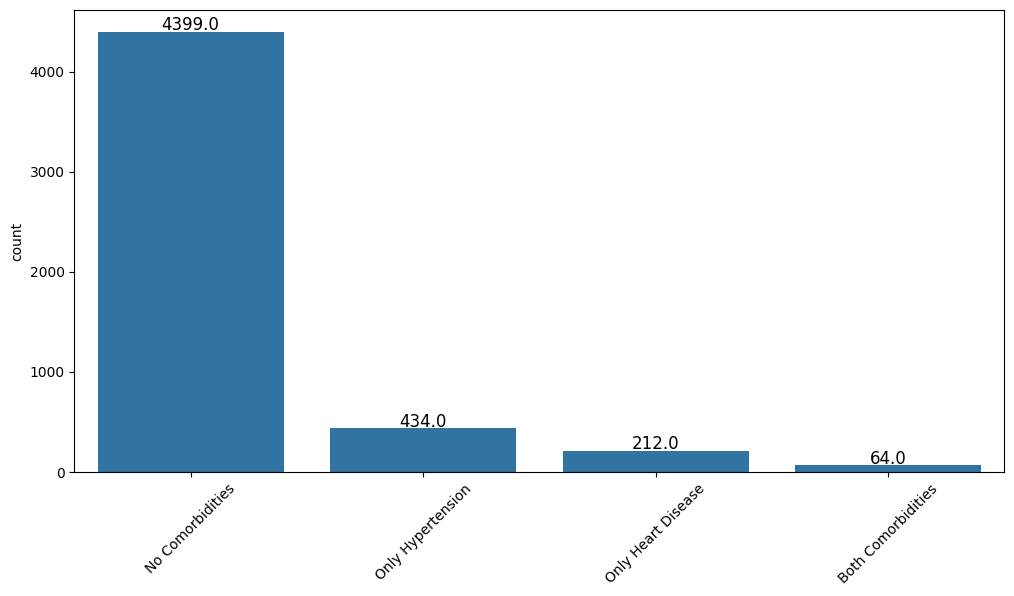

In [23]:
# Maps the labels to integers
mapping = {val: i for i, val in enumerate(values)}
key = disease_category.map(mapping)

# Plot the Disease Categories
plt.figure(figsize = (12, 6))
ax = sns.countplot(x = disease_category.iloc[key.argsort()])

# Write numbers on the columns
for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                fontsize = 12, color = 'black',
                xytext = (0, 5), textcoords = 'offset points')

plt.xlabel('')
plt.setp(ax.get_xticklabels(), rotation = 45)
plt.show()

**Pie Chart**

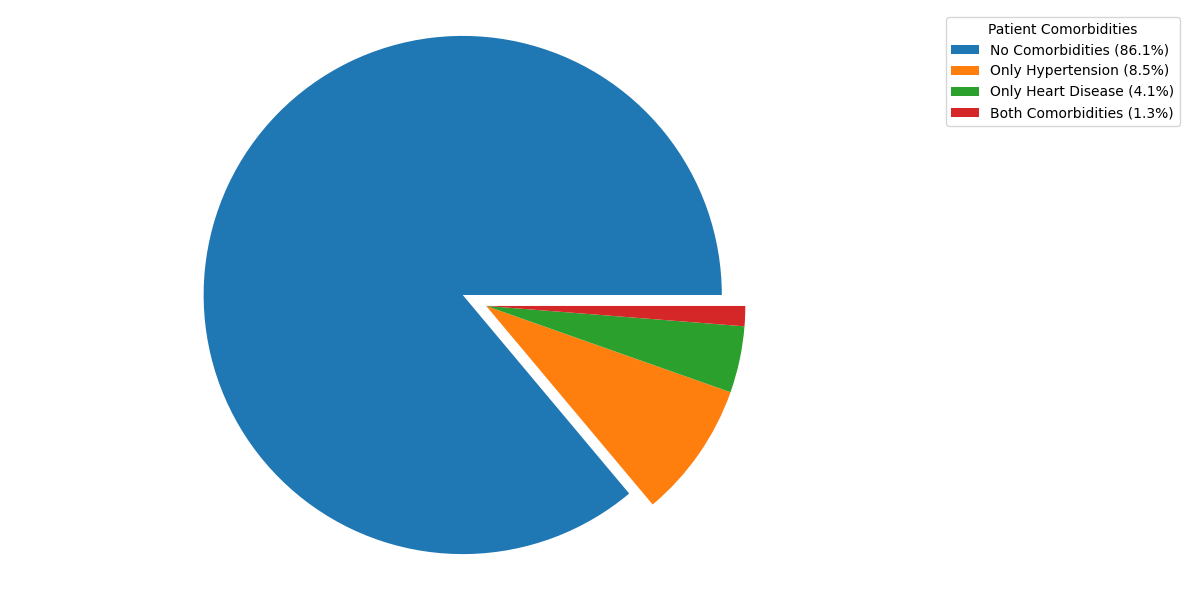

In [24]:
# Calculates the percentage of each disease category
pie_data = disease_category.value_counts(normalize = True).values * 100

# Creates labels for the pie chart
pie_label = [f'{l} ({s:0.1f}%)' for l, s in zip(values, pie_data)]

# Creates a pie chart
plt.figure(figsize = (12, 6))
wedges, texts = plt.pie(pie_data, startangle = 0, explode = [0.1, 0, 0, 0])
plt.axis('equal')     # Ensures the pie chart is a circle
plt.legend(wedges, pie_label, title = 'Patient Comorbidities', loc = 'upper left', bbox_to_anchor = (1, 0, 0.5, 1))     # Adds a legend to the pie chart
plt.tight_layout()      # Adjusts the layout to prevent overlap
plt.show()      # Displays the plot

Như chúng ta đã thấy, hầu hết bệnh nhân không có bệnh đi kèm. Sử dụng biểu đồ hình tròn là tốt nếu nó có thể cho chúng ta biết rõ về phần dữ liệu.

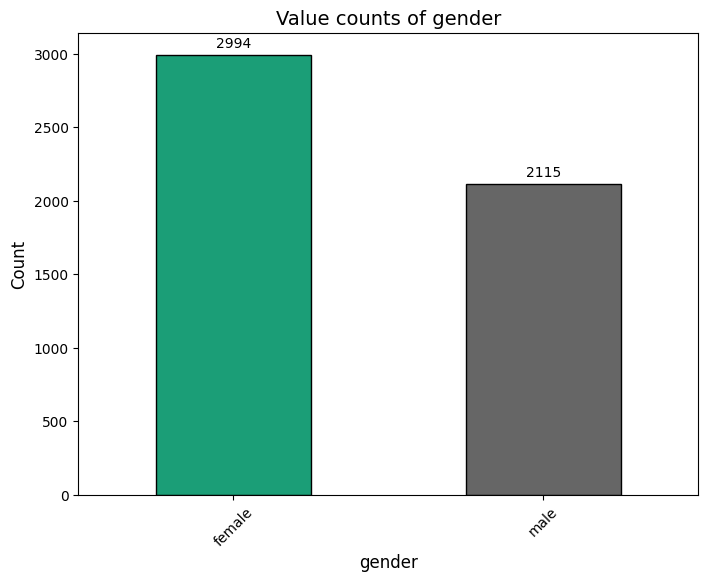

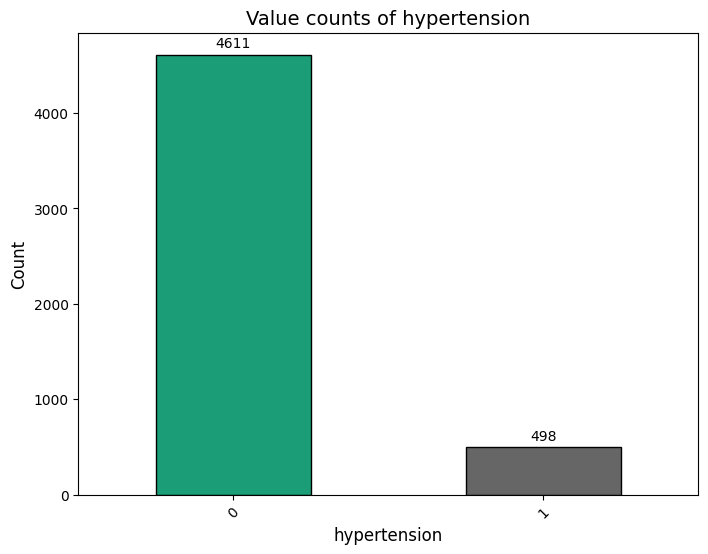

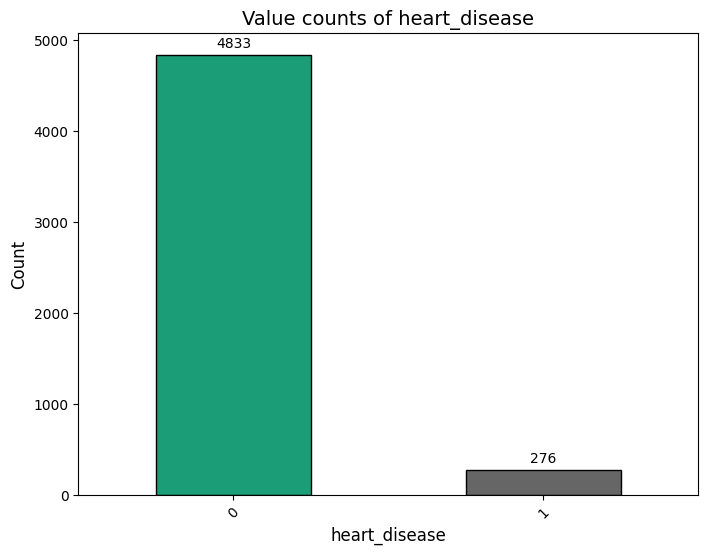

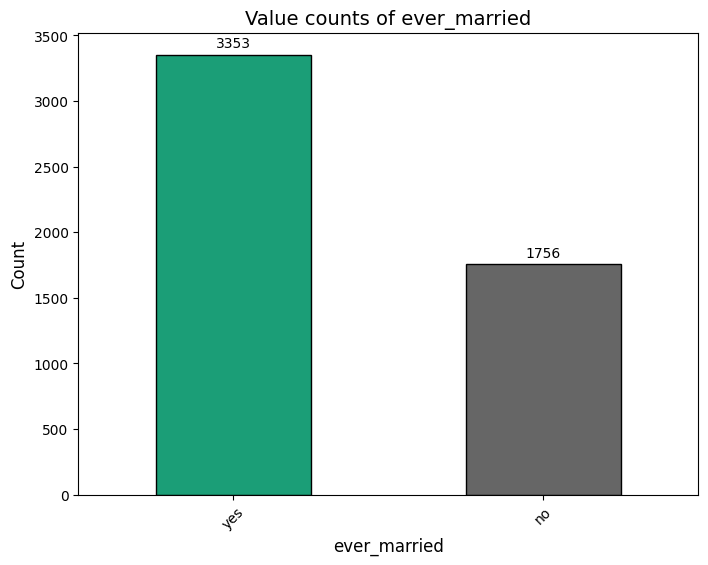

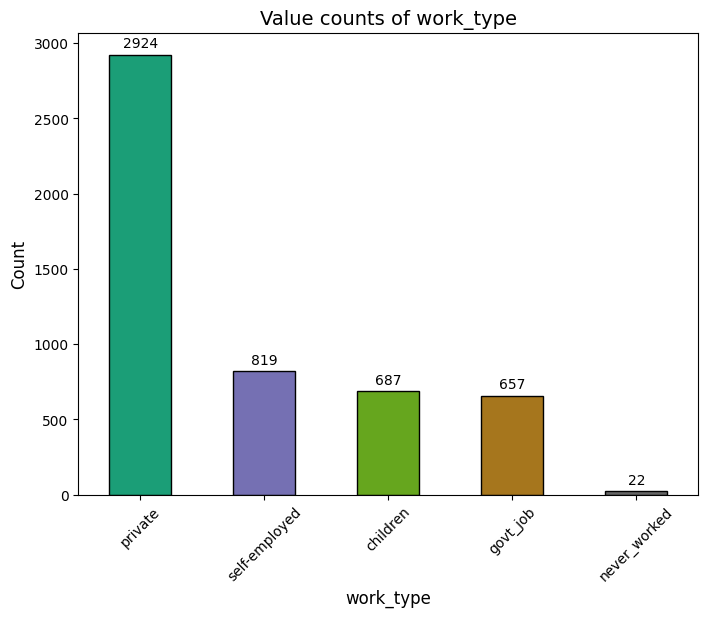

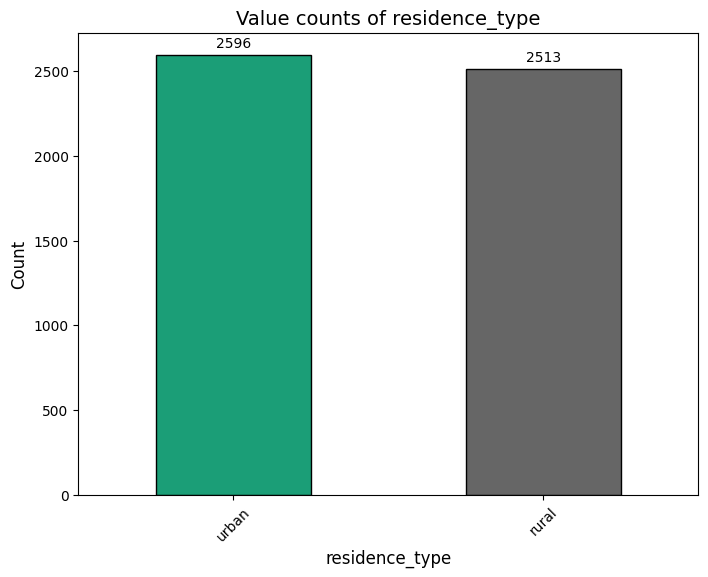

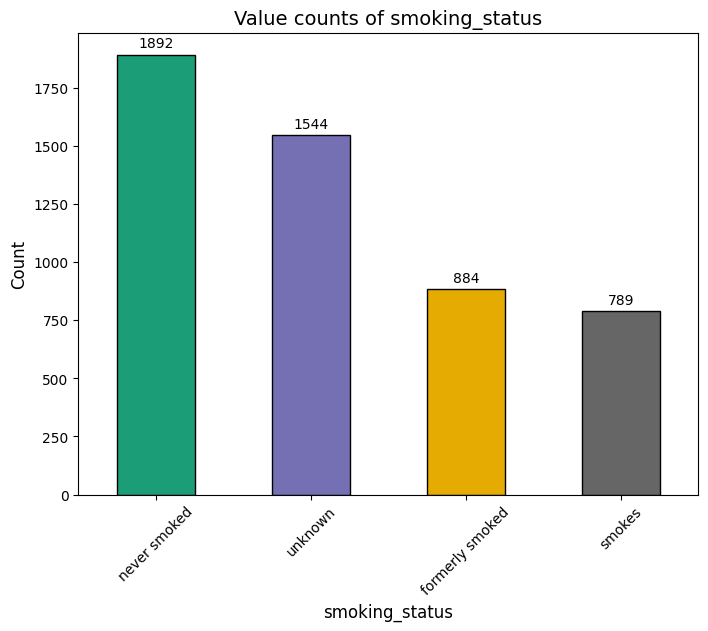

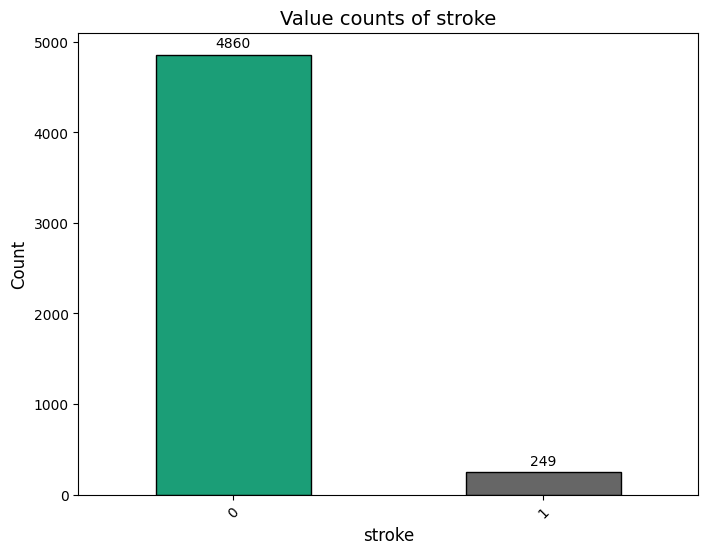

In [25]:
column_list = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'residence_type', 'smoking_status', 'stroke']

# Loop through each column and plot the chart
for col in column_list:
    value_counts = data[col].value_counts()

    # Use Dark2 color palette from matplotlib for each attribute
    num_colors = len(value_counts)
    colors = plt.cm.Dark2(np.linspace(0, 1, num_colors))      # Select bold color for each value

    # Create bar chart with separate color for each value
    plt.figure(figsize = (8, 6))
    ax = value_counts.plot(kind = 'bar', color = colors, edgecolor = 'black')

    # Add numbers to each column
    ax.bar_label(ax.containers[0], label_type = 'edge', fontsize = 10, color = 'black', padding = 3)

    # Set title and labels
    plt.title(f'Value counts of {col}', fontsize = 14)
    plt.xlabel(col, fontsize = 12)
    plt.ylabel('Count', fontsize = 12)
    plt.xticks(rotation = 45)

    # Displays the plot
    plt.show()

Số người bị đột quỵ quá thấp so với số người không bị đột quỵ
=> Biến target (Stroke) của bộ dữ liệu không cân bằng.

## Phân phối Stroke theo các thuộc tính phân loại
## (gender, hypertension, heart_disease, ever_married, work_type, residence_type, smoking_status)

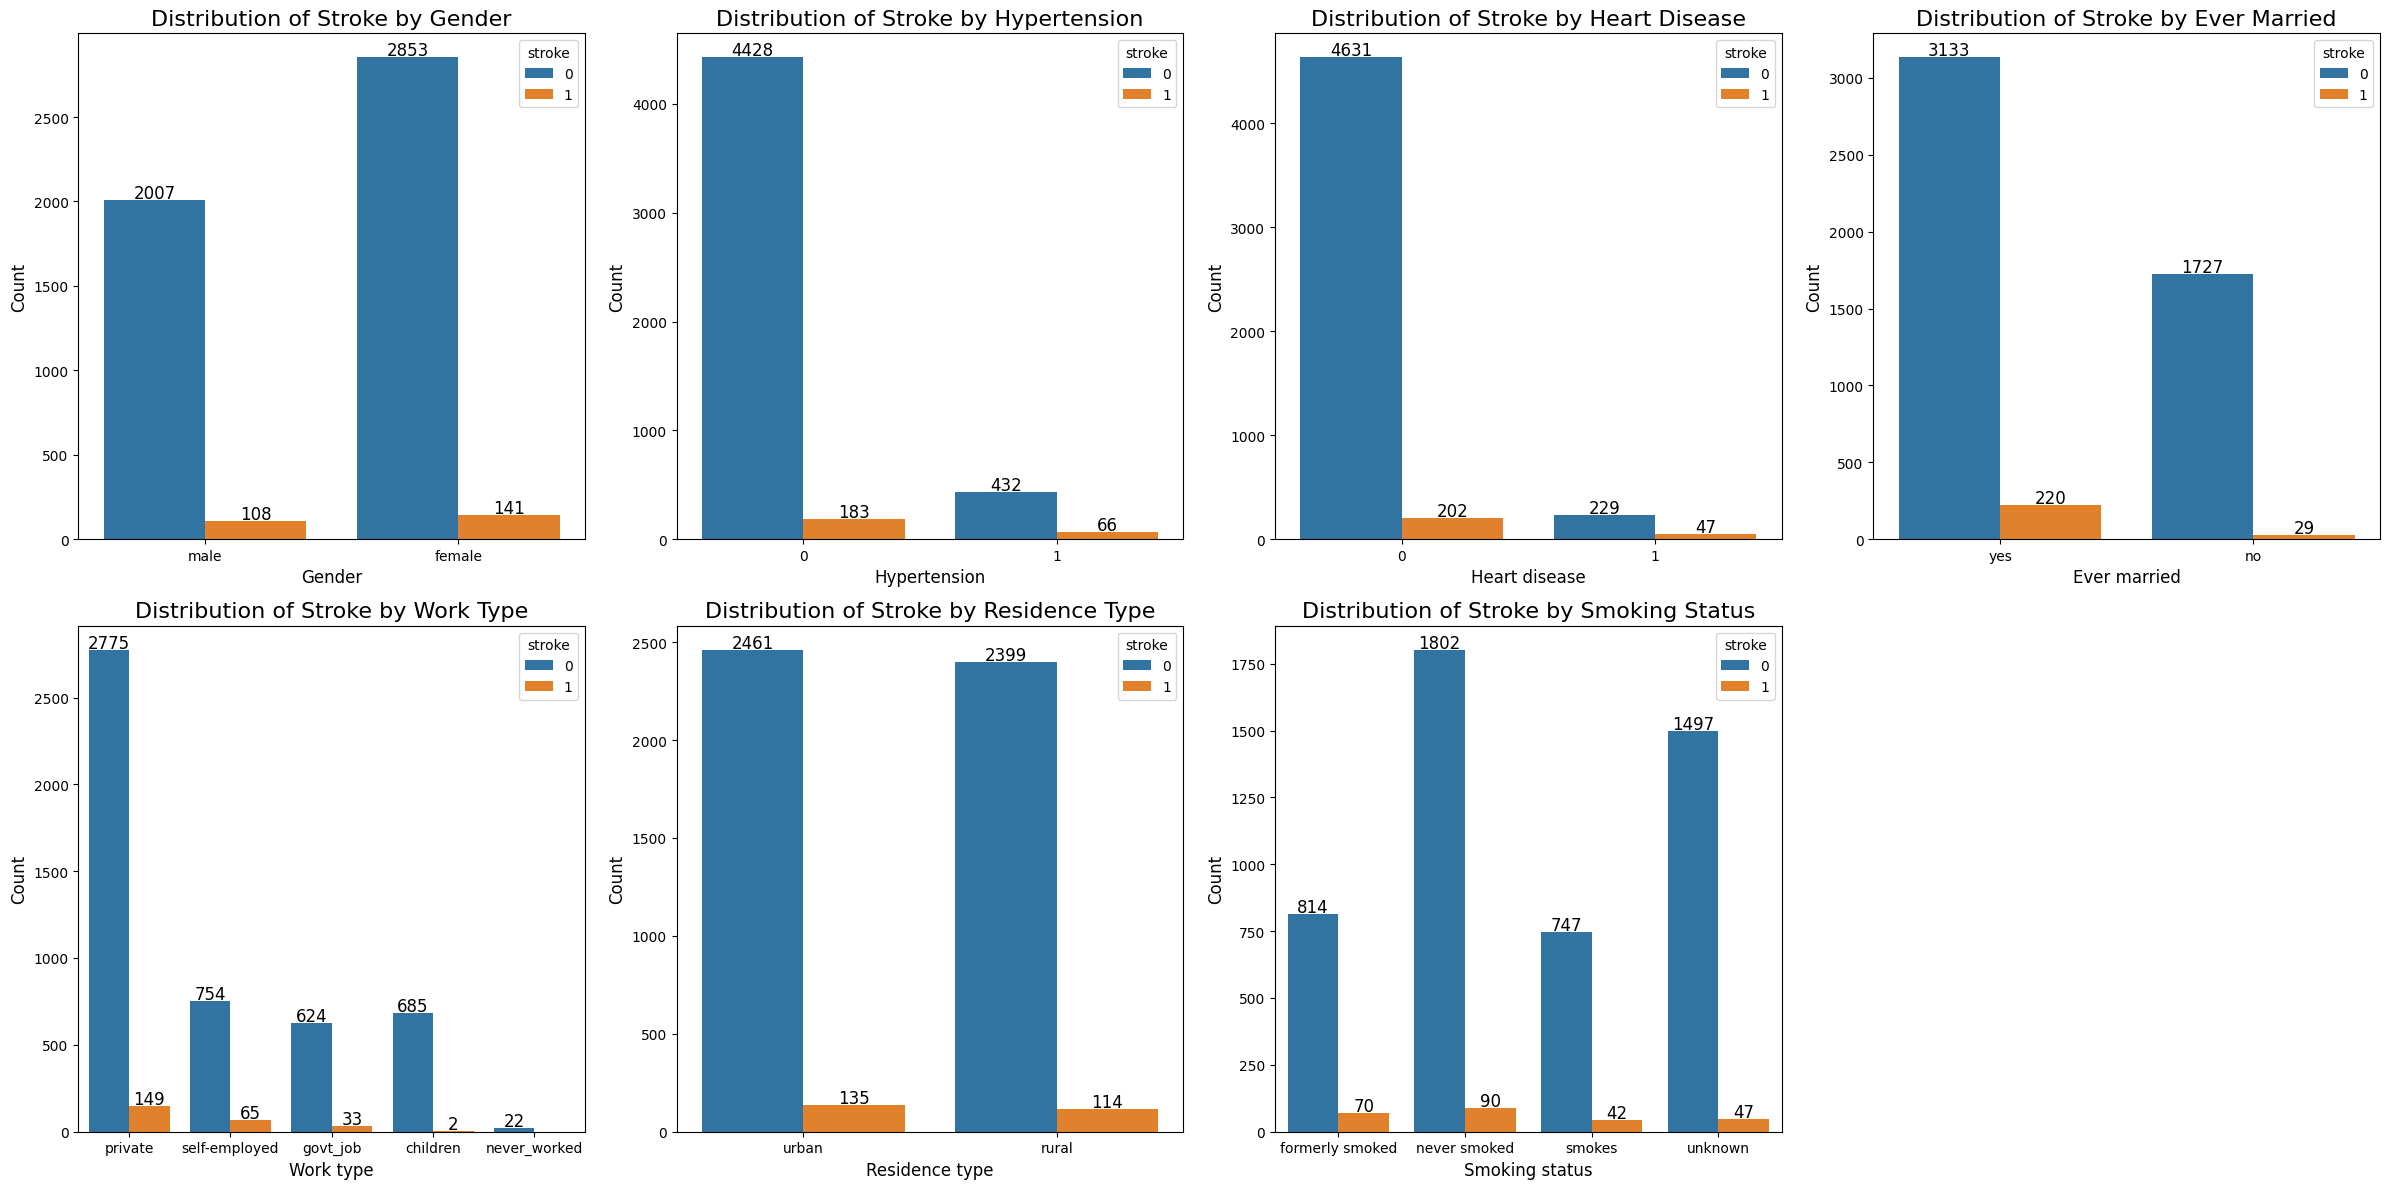

In [26]:
# Set up canvas with 2 rows x 4 columns
fig, axes = plt.subplots(2, 4, figsize = (24, 12))

# List of columns and titles
columns = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'residence_type', 'smoking_status']
titles = [
    "Distribution of Stroke by Gender",
    "Distribution of Stroke by Hypertension",
    "Distribution of Stroke by Heart Disease",
    "Distribution of Stroke by Ever Married",
    "Distribution of Stroke by Work Type",
    "Distribution of Stroke by Residence Type",
    "Distribution of Stroke by Smoking Status"
]

# Loop through each column and plot the chart
for i, column in enumerate(columns):
    row = i // 4      # Identify the row
    col = i % 4       # Identify the column
    ax = axes[row, col]
    sns.countplot(x = column, hue = 'stroke', data = data, ax = ax)
    ax.set_title(titles[i], fontsize = 16)
    ax.set_xlabel(column.replace('_', ' ').capitalize(), fontsize = 12)
    ax.set_ylabel("Count", fontsize = 12)

    # Add numbers to each column
    for p in ax.patches:
        height = p.get_height()
        if height > 0:      # Only display number if value > 0
            ax.annotate(f'{int(height)}',
                        (p.get_x() + p.get_width() / 2., height),
                        ha = 'center', va = 'center', fontsize = 12, color = 'black',
                        xytext = (0, 5), textcoords = 'offset points')

# Hide redundant charts (if any)
if len(columns) % 4 != 0:
    for j in range(len(columns), 4 * 2):      # Total 8 charts
        fig.delaxes(axes[j // 4, j % 4])

# Align spacing and display charts
plt.tight_layout()
plt.show()

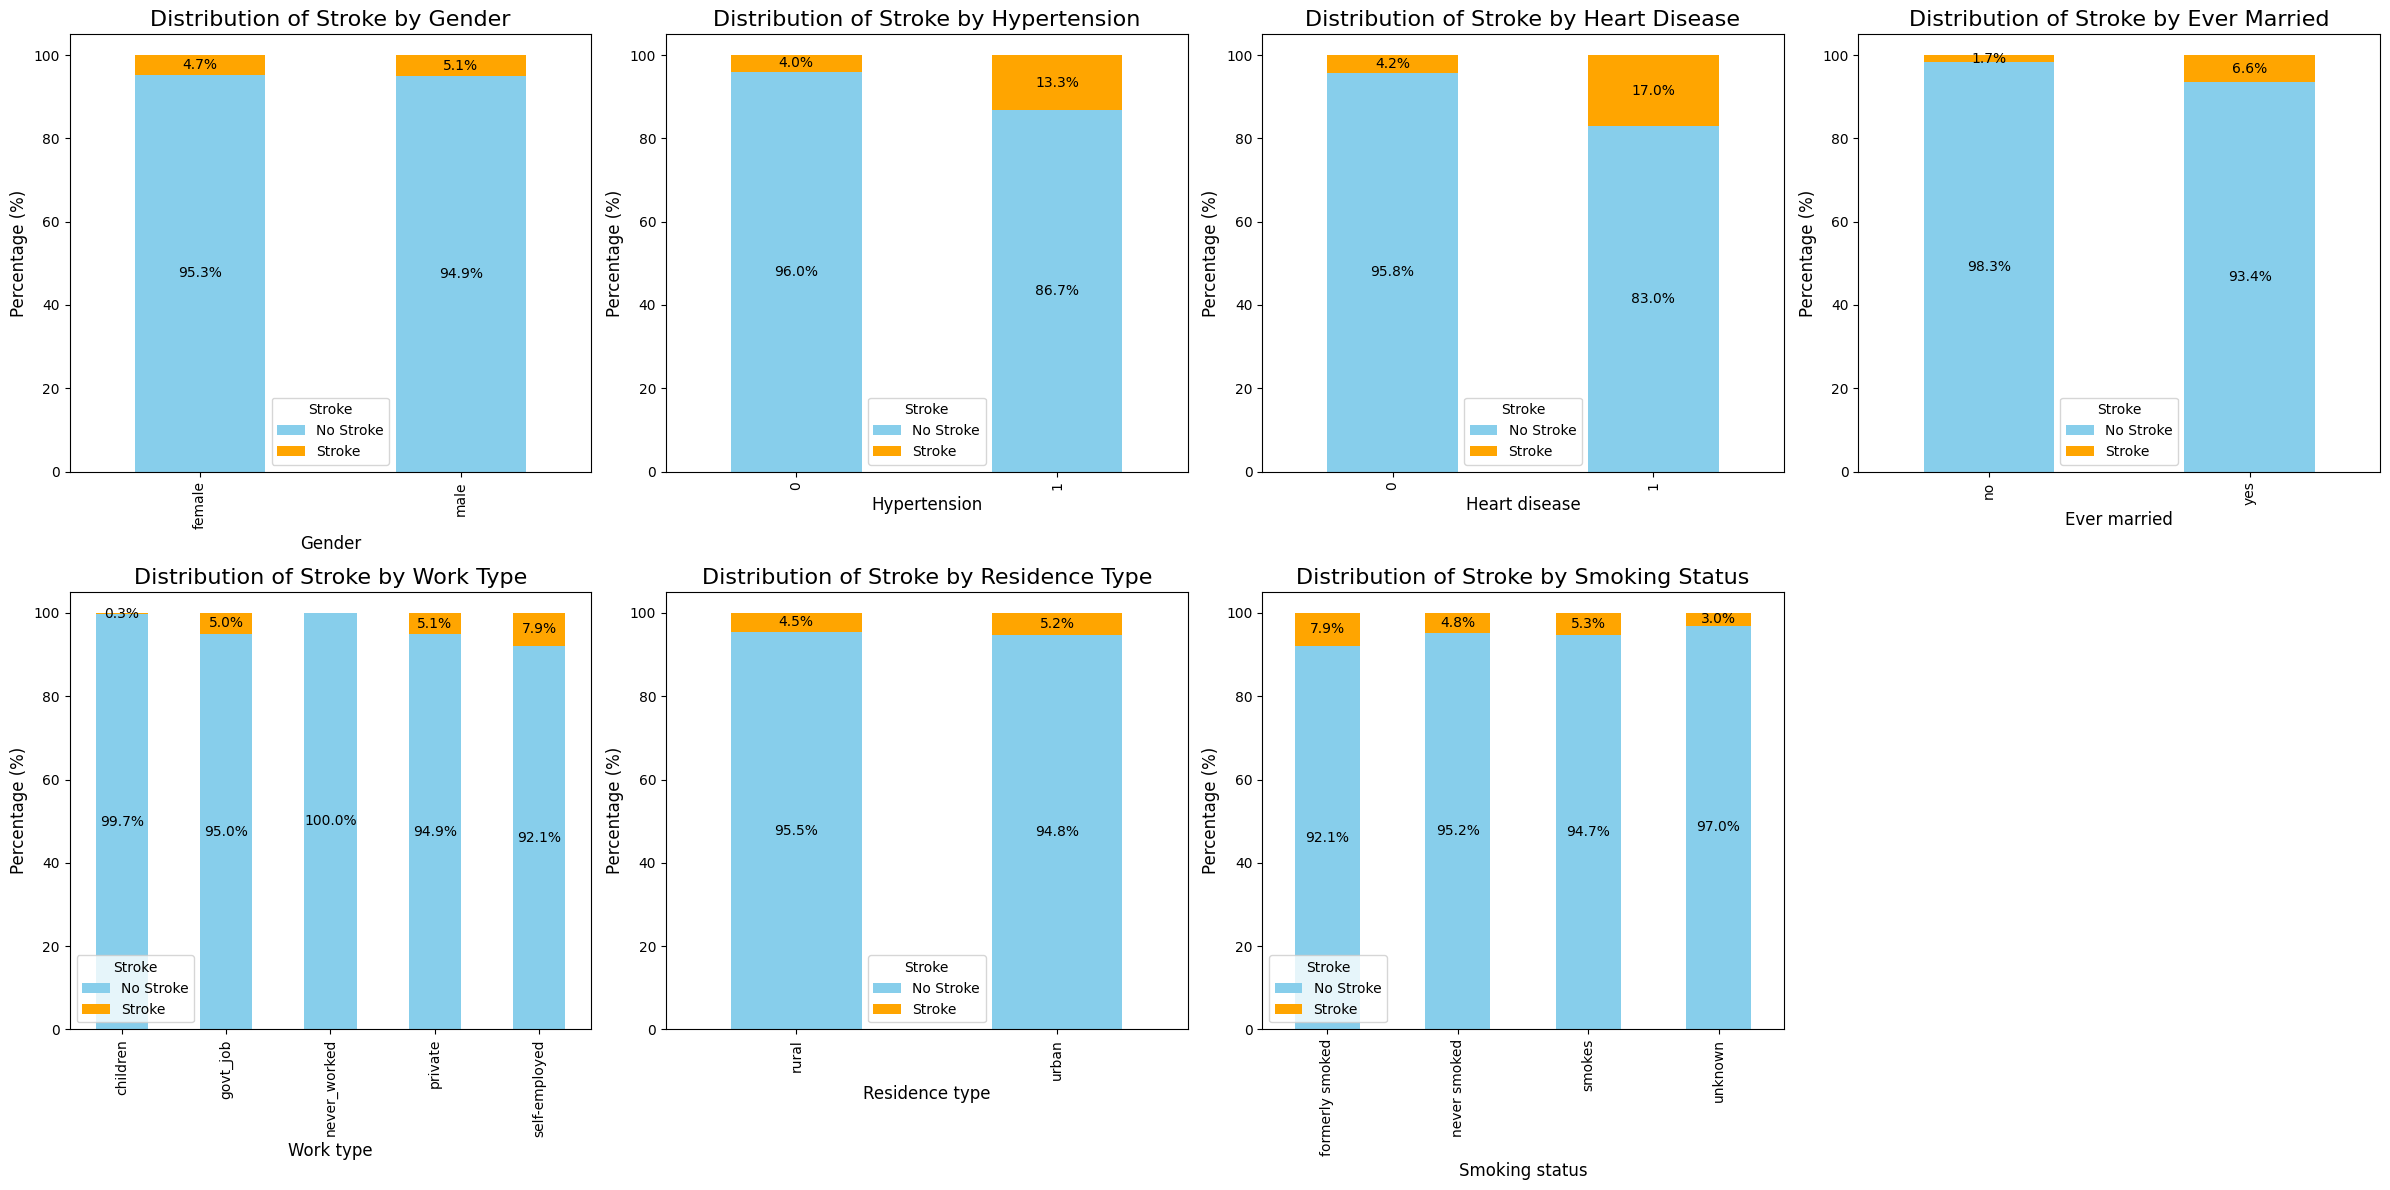

In [27]:
# Set up canvas with 2 rows x 4 columns
fig, axes = plt.subplots(2, 4, figsize = (24, 12))

# List of columns and titles
columns = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'residence_type', 'smoking_status']
titles = [
    "Distribution of Stroke by Gender",
    "Distribution of Stroke by Hypertension",
    "Distribution of Stroke by Heart Disease",
    "Distribution of Stroke by Ever Married",
    "Distribution of Stroke by Work Type",
    "Distribution of Stroke by Residence Type",
    "Distribution of Stroke by Smoking Status"
]

# Loop through each column and plot the chart
for i, column in enumerate(columns):
    row = i // 4      # Identify the row
    col = i % 4       # Identify the column
    ax = axes[row, col]

    # Calculate percentage
    percentages = (
        data.groupby([column, 'stroke']).size() / data.groupby(column).size() * 100
    ).unstack()

    # Plot the chart
    percentages.plot(kind = 'bar', stacked = True, ax = ax, color = ['skyblue', 'orange'])

    # Set title and labels
    ax.set_title(titles[i], fontsize = 16)
    ax.set_xlabel(column.replace('_', ' ').capitalize(), fontsize = 12)
    ax.set_ylabel("Percentage (%)", fontsize = 12)
    ax.legend(title = "Stroke", labels = ['No Stroke', 'Stroke'])

    # Display percentage on column
    for p in ax.patches:
        height = p.get_height()
        if height > 0:      # Only display number if value > 0
            ax.annotate(f'{height:.1f}%',
                        (p.get_x() + p.get_width() / 2., p.get_y() + height / 2),
                        ha = 'center', va = 'center', fontsize = 10, color = 'black')

# Hide redundant charts (if any)
if len(columns) % 4 != 0:
    for j in range(len(columns), 4 * 2):      # Total 8 charts
        fig.delaxes(axes[j // 4, j % 4])

# Align spacing and display charts
plt.tight_layout()
plt.show()

## Phân phối các thuộc tính smoking_status, work_type, residence_type theo gender

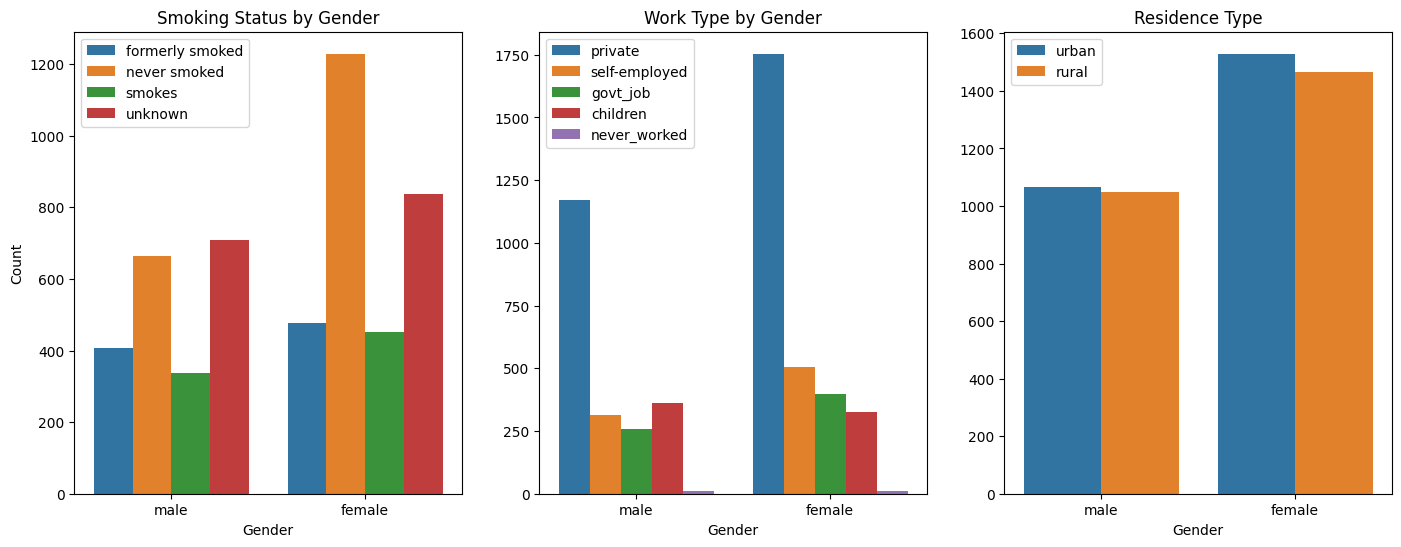

In [28]:
plt.figure(figsize = (17, 6))

plt.subplot(1, 3, 1)
sns.countplot(x = data['gender'], hue = 'smoking_status', data = data);
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Smoking Status by Gender')
plt.legend()

plt.subplot(1, 3, 2)
g1 = sns.countplot(x = data['gender'], hue = 'work_type', data = data);
plt.xlabel('Gender')
g1.set(ylabel = None)
plt.title('Work Type by Gender')
plt.legend()

plt.subplot(1, 3, 3)
g1 = sns.countplot(x = data['gender'], hue = 'residence_type', data = data);
plt.xlabel('Gender')
g1.set(ylabel = None)
plt.title('Residence Type')
plt.legend()

plt.show()

* Nhiều phụ nữ không bao giờ hút thuốc, đồng thời, tình trạng 'unknow' cũng chiếm số lượng lớn
* Đối với cả hai giới, nhiều người đang làm việc ở khu vực tư nhân.
* Ở cột Loại nơi cư trú, số lượng nam giới và phụ nữ sống ở cả khu vực thành thị và nông thôn là như nhau.

## Phân phối stroke theo các thuộc tính age, avg_glucose_level, bmi

**Histogram**

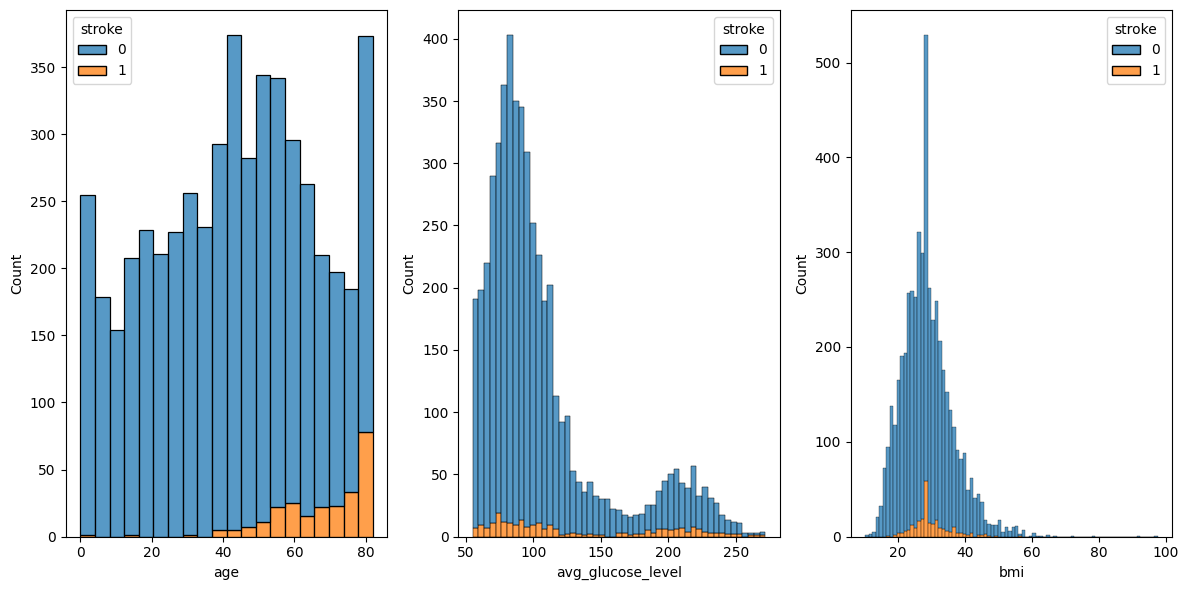

In [29]:
column_list = ['age', 'avg_glucose_level', 'bmi']

fig, ax = plt.subplots(1, 3, figsize = (12, 6))      # Create a figure with 1x3 subplots

for i, col in enumerate(column_list):
  sns.histplot(data = data, x = col, hue = 'stroke', multiple = 'stack', ax = ax[i])

plt.tight_layout()
plt.show()

Bộ dữ liệu của chúng tôi dường như không tuân theo phân phối chuẩn, đặc biệt là các thuộc tính avg_glucose_level và bmi có dạng lệch phải.

**Density Chart**

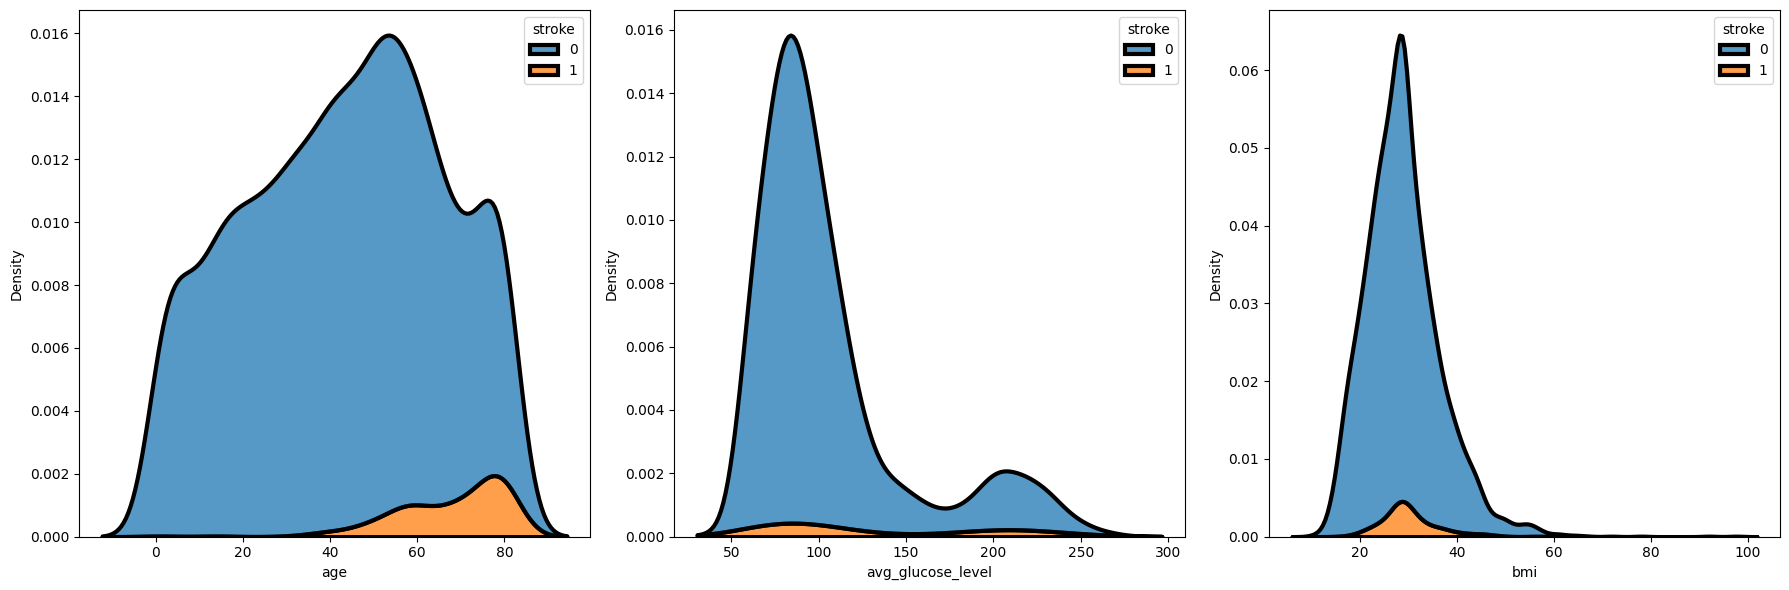

In [30]:
column_list = ['age', 'avg_glucose_level', 'bmi']

fig, ax = plt.subplots(1, 3, figsize = (18, 6))      # Create a figure with 1x3 subplots

for i, col in enumerate(column_list):
  sns.kdeplot(data = data, x = col, linewidth = 3, hue = 'stroke', fill = True, multiple = 'stack', ax = ax[i])

plt.tight_layout()
plt.show()

Chỉ cần nhìn lướt qua, chúng ta có thể thấy rằng hầu hết bệnh nhân bị đột quỵ đều ở độ tuổi từ 60-80.

**Box Plot**

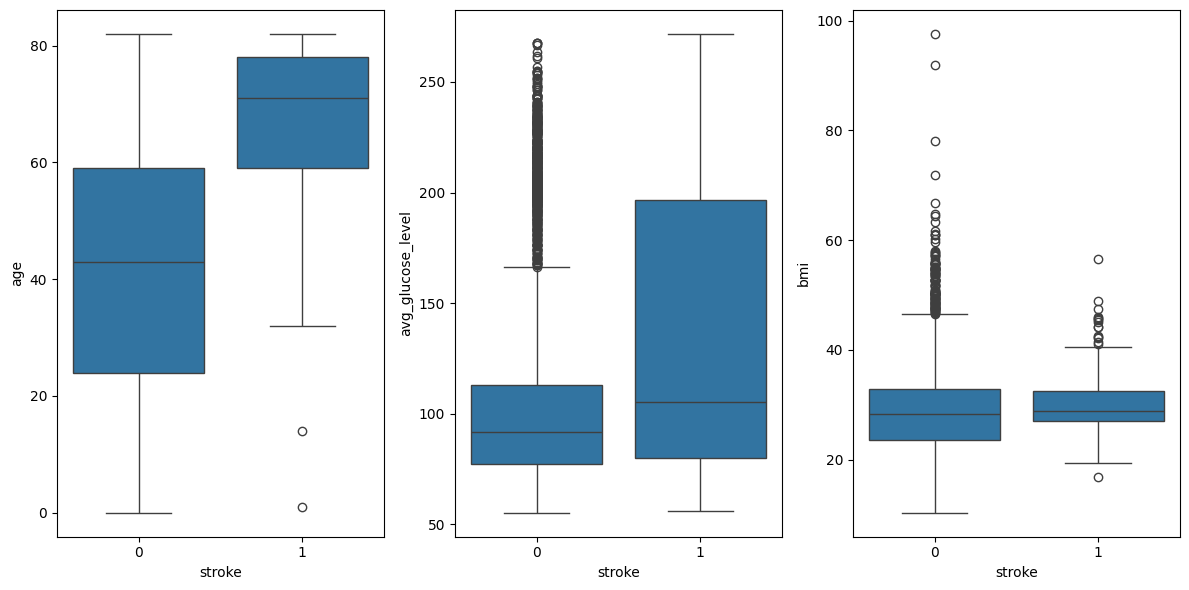

In [31]:
column_list = ['age', 'avg_glucose_level', 'bmi']

fig, ax = plt.subplots(1, 3, figsize = (12, 6))      # Create a figure with 1x3 subplots

for i, col in enumerate(column_list):
  sns.boxplot(data = data, x = 'stroke', y = col, ax = ax[i])

plt.tight_layout()
plt.show()

Nếu chúng ta phân chia dữ liệu dựa trên thuộc tính đột quỵ, chúng ta sẽ có được một số thông tin quan trọng:

*   Hầu hết bệnh nhân bị đột quỵ đều trên 60 tuổi.
*   Tuy nhiên, vẫn có khả năng những người trẻ tuổi cũng có thể bị đột quỵ, vì chúng ta có thể thấy có một số trường hợp ngoại lệ.
*   Chúng ta có thể cho rằng độ tuổi của bệnh nhân có mối tương quan với việc bệnh nhân có bị đột quỵ hay không.
*  Chỉ số BMI thường nằm trong khoảng từ 20 đến 40.

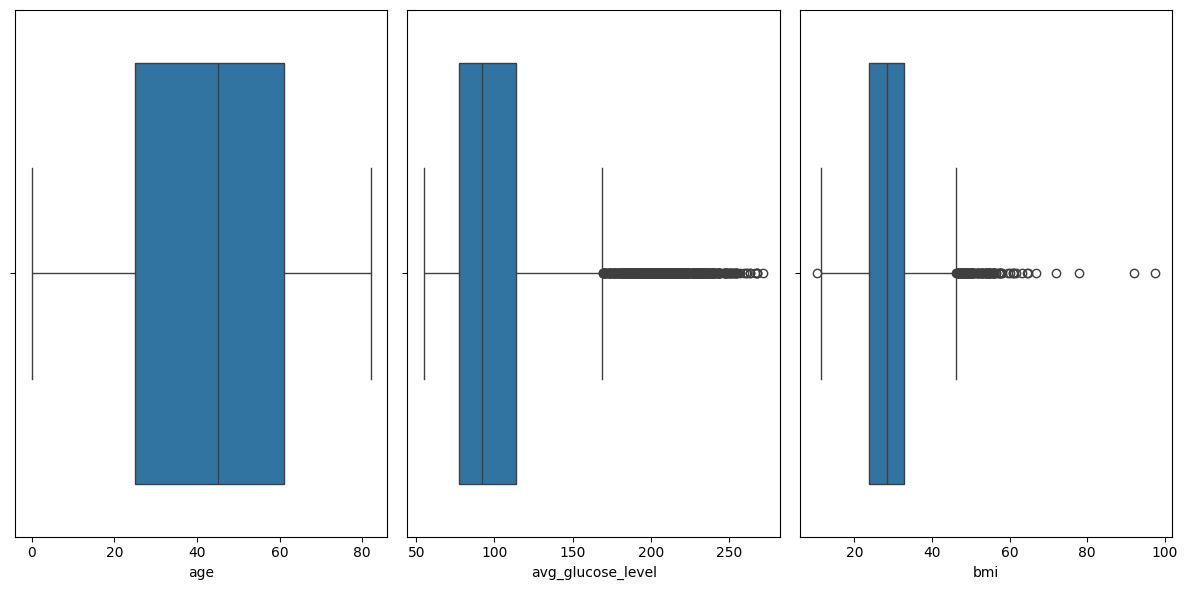

In [32]:
column_list = ['age', 'avg_glucose_level', 'bmi']

fig, ax = plt.subplots(1, 3, figsize = (12, 6))      # Create a figure with 1x3 subplots

for i, col in enumerate(column_list):
  sns.boxplot(data = data, x = col, ax = ax[i])

plt.tight_layout()
plt.show()

Khi sử dụng biểu đồ hộp, chúng ta có thể thấy có nhiều giá trị ngoại lai trên các thuộc tính avg_glucose_level và bmi.

## Mối quan hệ giữa age với avg_glucose_level, bmi

**Scatter Plot**

Biểu đồ phân tán thường được sử dụng để xem mối tương quan giữa các thuộc tính. Giả sử, chúng ta muốn biết mối tương quan giữa:
1. Tuổi bệnh nhân và Mức glucose trung bình
2. Tuổi bệnh nhân và Chỉ số BMI

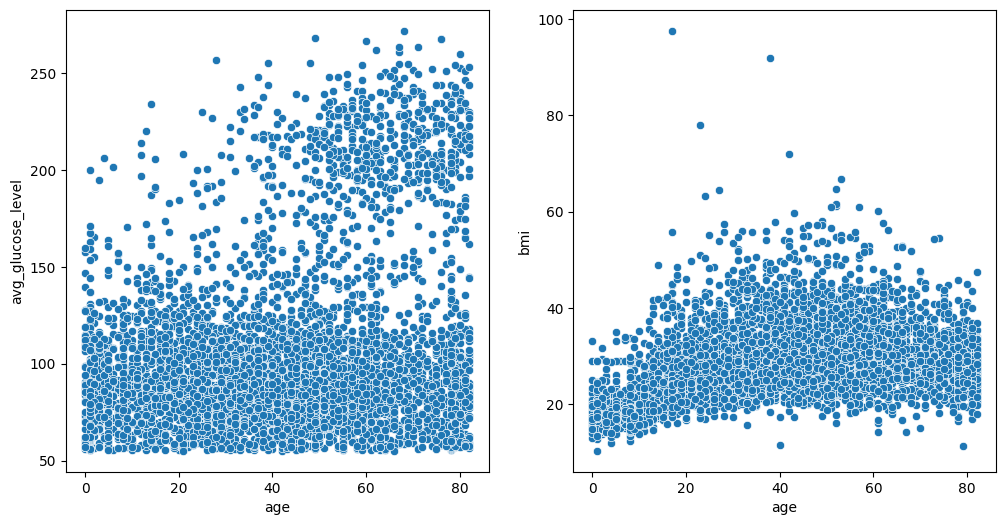

In [33]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))      # Create a figure with 1x2 subplots

sns.scatterplot(data = data, x = 'age', y = 'avg_glucose_level', ax = ax[0])
sns.scatterplot(data = data, x = 'age', y = 'bmi', ax = ax[1])

plt.show()

Từ biểu đồ phân tán, ta nhận thấy không có mối tương quan rõ ràng giữa tuổi và mức đường huyết trung bình (avg_glucose_level), vì các điểm dữ liệu phân tán khá rời rạc. Tuy nhiên, giữa tuổi và chỉ số BMI có một mối tương quan rõ rệt, cho thấy người cao tuổi có xu hướng có chỉ số BMI cao hơn. Điều này có thể do các yếu tố sinh lý như lối sống và chế độ ăn uống thay đổi theo độ tuổi.

## Phân phối age theo heart disease, hypertension

/tmp/ipython-input-89057486.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'heart_disease', y = 'age', data = data, palette = 'muted')
/tmp/ipython-input-89057486.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'hypertension', y = 'age', data = data, palette = 'muted')


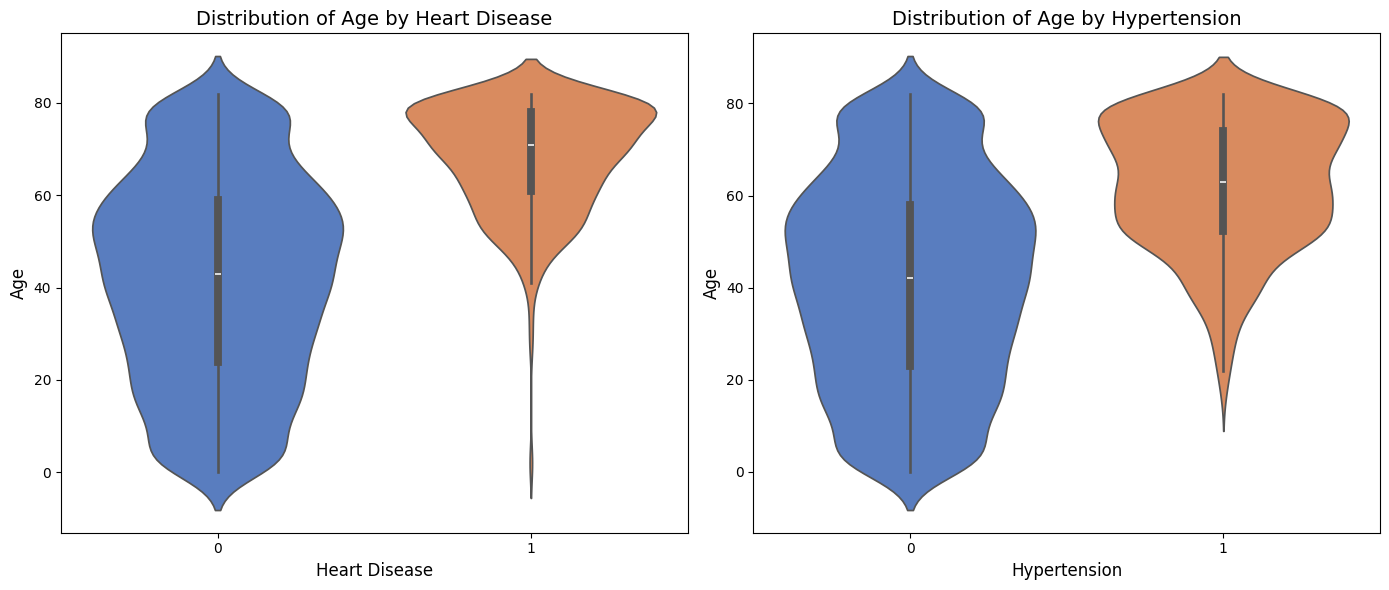

In [34]:
# Tạo một figure và chia thành 2 cột
plt.figure(figsize = (14, 6))

# Biểu đồ violin giữa Age và Heart Disease
plt.subplot(1, 2, 1)  # 1 row, 2 columns, chọn biểu đồ thứ 1
sns.violinplot(x = 'heart_disease', y = 'age', data = data, palette = 'muted')
plt.xlabel('Heart Disease', fontsize = 12)
plt.ylabel('Age', fontsize = 12)
plt.title('Distribution of Age by Heart Disease', fontsize = 14)

# Biểu đồ violin giữa Age và Hypertension
plt.subplot(1, 2, 2)  # 1 row, 2 columns, chọn biểu đồ thứ 2
sns.violinplot(x = 'hypertension', y = 'age', data = data, palette = 'muted')
plt.xlabel('Hypertension', fontsize = 12)
plt.ylabel('Age', fontsize = 12)
plt.title('Distribution of Age by Hypertension', fontsize = 14)

# Hiển thị biểu đồ
plt.tight_layout()  # Đảm bảo các biểu đồ không bị chồng lên nhau
plt.show()

<Axes: xlabel='hypertension', ylabel='age'>

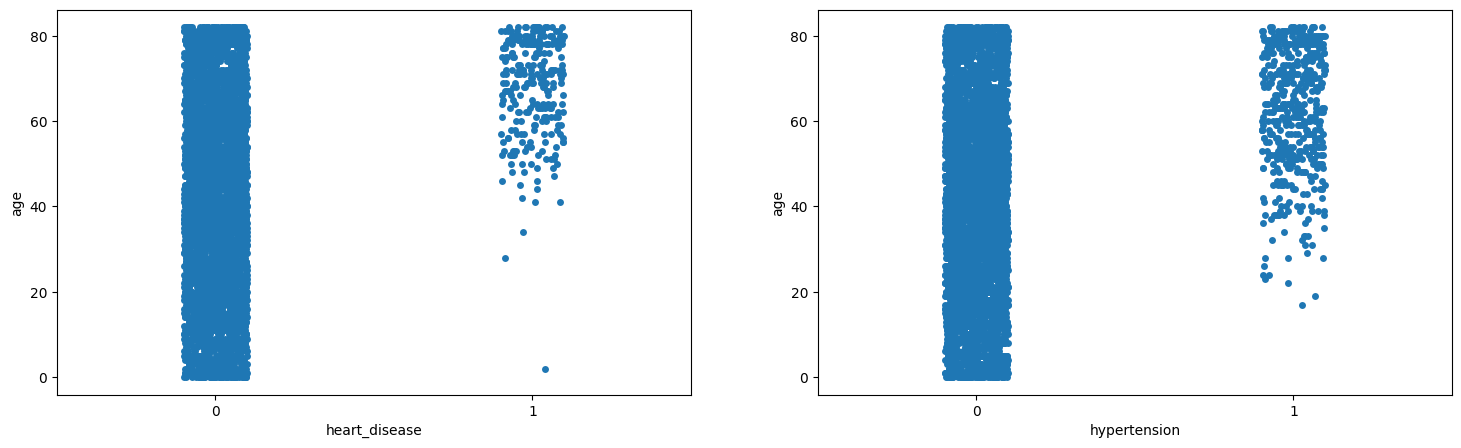

In [35]:
plt.figure(figsize = (18, 5))
plt.subplot(1, 2, 1)
sns.stripplot(data = data, x = 'heart_disease', y = 'age')
plt.subplot(1, 2, 2)
sns.stripplot(data = data, x = 'hypertension', y = 'age')

* Nguy cơ mắc bệnh tăng huyết áp tăng ở những người trên 50 tuổi.
* Nguy cơ mắc bệnh tim tăng ở những người trên 50 tuổi.

# 3. DATA PRE-PROCESSING

In [36]:
data

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,male,67,0,1,yes,private,urban,228.69,36.600000,formerly smoked,1
1,female,61,0,0,yes,self-employed,rural,202.21,28.893237,never smoked,1
2,male,80,0,1,yes,private,rural,105.92,32.500000,never smoked,1
3,female,49,0,0,yes,private,urban,171.23,34.400000,smokes,1
4,female,79,1,0,yes,self-employed,rural,174.12,24.000000,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,female,80,1,0,yes,private,urban,83.75,28.893237,never smoked,0
5106,female,81,0,0,yes,self-employed,urban,125.20,40.000000,never smoked,0
5107,female,35,0,0,yes,self-employed,rural,82.99,30.600000,never smoked,0
5108,male,51,0,0,yes,private,rural,166.29,25.600000,formerly smoked,0


In [37]:
le = LabelEncoder()
lst = ['gender', 'ever_married', 'work_type', 'residence_type', 'smoking_status']
label_mapping = {}

data = data.copy()

for i in lst:
    data.loc[:, i] = le.fit_transform(data[i])
    label_mapping[i] = dict(zip(le.classes_, range(len(le.classes_))))

for feature, mapping in label_mapping.items():
    print(f"{feature} mapping: ")
    for label_str, number in mapping.items():
        print(f"   {label_str}: {number}")

gender mapping: 
   female: 0
   male: 1
ever_married mapping: 
   no: 0
   yes: 1
work_type mapping: 
   children: 0
   govt_job: 1
   never_worked: 2
   private: 3
   self-employed: 4
residence_type mapping: 
   rural: 0
   urban: 1
smoking_status mapping: 
   formerly smoked: 0
   never smoked: 1
   smokes: 2
   unknown: 3


In [38]:
data

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67,0,1,1,3,1,228.69,36.600000,0,1
1,0,61,0,0,1,4,0,202.21,28.893237,1,1
2,1,80,0,1,1,3,0,105.92,32.500000,1,1
3,0,49,0,0,1,3,1,171.23,34.400000,2,1
4,0,79,1,0,1,4,0,174.12,24.000000,1,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,0,80,1,0,1,3,1,83.75,28.893237,1,0
5106,0,81,0,0,1,4,1,125.20,40.000000,1,0
5107,0,35,0,0,1,4,0,82.99,30.600000,1,0
5108,1,51,0,0,1,3,0,166.29,25.600000,0,0


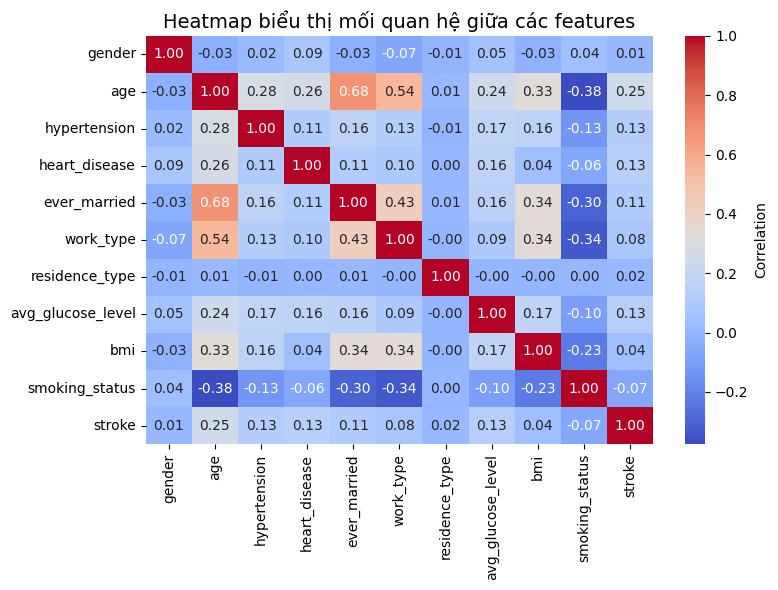

In [39]:
# Tính toán ma trận tương quan
correlation_matrix = data.corr()

# Vẽ heatmap với seaborn
plt.figure(figsize = (8, 6))
sns.heatmap(correlation_matrix, annot = True, fmt = ".2f", cmap = "coolwarm", cbar_kws = {'label': 'Correlation'})

# Thêm tiêu đề và điều chỉnh hiển thị
plt.title("Heatmap biểu thị mối quan hệ giữa các features", fontsize = 14)
plt.xticks(rotation = 90)
plt.yticks(rotation = 0)
plt.tight_layout()

# Hiển thị heatmap
plt.show()

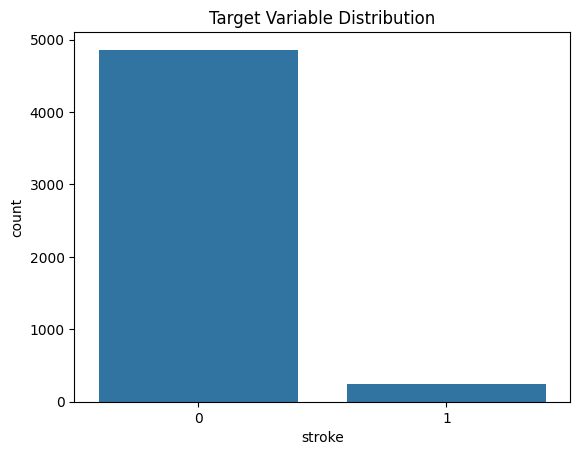

In [40]:
# Biểu đồ phân phối biến mục tiêu
sns.countplot(data = data, x = 'stroke')
plt.title("Target Variable Distribution")

plt.show()

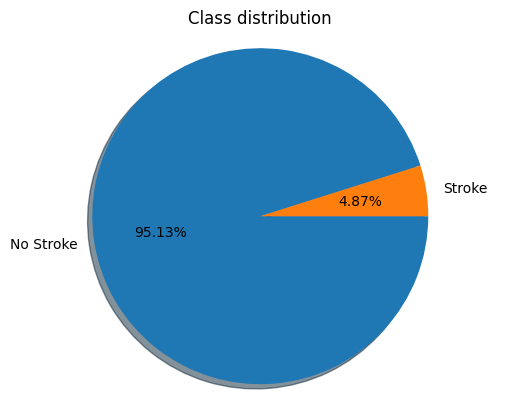

Samples associated with no stroke: 4860
Samples associated with stroke: 249


In [41]:
class_occur = data['stroke'].value_counts()
class_names = ['No Stroke', 'Stroke']

fig, ax = plt.subplots()
ax.pie(class_occur, labels = class_names, autopct = '%1.2f%%',
        shadow = True, startangle = 0, counterclock = False)
ax.axis('equal')      # Equal aspect ratio ensures that pie is drawn as a circle.
ax.set_title('Class distribution')
plt.show()

print("Samples associated with no stroke: {}".format(class_occur[0]))
print("Samples associated with stroke: {}".format(class_occur[1]))

In [42]:
X = data.drop(['stroke'], axis = 1)
y = data['stroke']

In [43]:
# Initializes a SMOTE (Synthetic Minority Over-sampling Technique) object
smote = SMOTE(sampling_strategy = 'minority')

# Resampling to oversample the minority class to balance the dataset
X, y = smote.fit_resample(data.loc[:, data.columns != 'stroke'], data['stroke'])

print("Shape of X: {}".format(X.shape))
print("Shape of y: {}".format(y.shape))

Shape of X: (9720, 10)
Shape of y: (9720,)


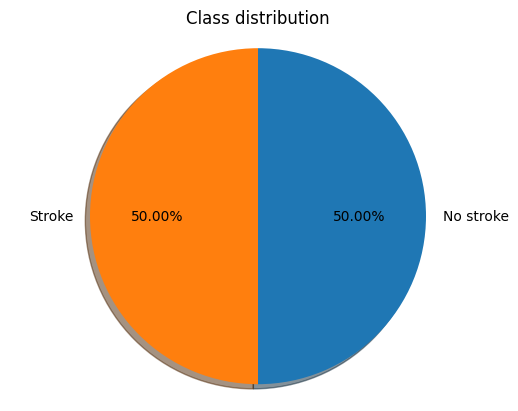

Samples associated with no stroke: 4860
Samples associated with stroke: 4860


In [44]:
# Class Distribution After SMOTE
_, class_counts = np.unique(y, return_counts = True)
class_names = ['No stroke', 'Stroke']

fig, ax = plt.subplots()
ax.pie(class_counts, labels = class_names, autopct = '%1.2f%%',
        shadow = True, startangle = 90, counterclock = False)
ax.axis('equal')      # Equal aspect ratio ensures that pie is drawn as a circle.
ax.set_title('Class distribution')
plt.show()

print("Samples associated with no stroke: {}".format(class_counts[0]))
print("Samples associated with stroke: {}".format(class_counts[1]))

In [45]:
print(len(X))
print(len(y))

9720
9720


In [46]:
data = pd.concat([X, y], axis = 1)

In [47]:
data

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1.0,67,0,1,1.0,3.0,1.0,228.690000,36.600000,0.0,1
1,0.0,61,0,0,1.0,4.0,0.0,202.210000,28.893237,1.0,1
2,1.0,80,0,1,1.0,3.0,0.0,105.920000,32.500000,1.0,1
3,0.0,49,0,0,1.0,3.0,1.0,171.230000,34.400000,2.0,1
4,0.0,79,1,0,1.0,4.0,0.0,174.120000,24.000000,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...
9715,1.0,60,0,0,1.0,2.264159,1.0,211.026309,25.694815,2.632079,1
9716,0.773728,79,0,0,1.0,3.226272,0.0,106.723264,32.115338,1.0,1
9717,0.627866,60,0,0,1.0,3.0,1.0,156.425699,28.018471,0.372134,1
9718,0.0,70,0,0,0.407989,3.0,0.592011,95.830201,24.472755,1.407989,1


# 4. PREPARE DATA FOR TRAINING

## StandardScaler

In [48]:
# Standardize Features
scaler = StandardScaler()

# scaler = scaler.fit(X)      # Fits the scaler to the training data
# X_std = scaler.transform(X)     # Transforms the training data using the fitted scaler

X_std = scaler.fit_transform(X)     # Fits the scaler to the training data and transforms it using the fitted scaler

In [49]:
X_std

array([[ 1.23954972,  0.5563544 , -0.30816313, ...,  1.95375362,
         1.08738946, -1.41448817],
       [-0.94801709,  0.28349221, -0.30816313, ...,  1.47963998,
        -0.0849506 , -0.42905179],
       [ 1.23954972,  1.14755581, -0.30816313, ..., -0.24439335,
         0.46370424, -0.42905179],
       ...,
       [ 0.42548125,  0.23801518, -0.30816313, ...,  0.65989067,
        -0.21801852, -1.04777357],
       [-0.94801709,  0.69278549, -0.30816313, ..., -0.42504709,
        -0.75738699, -0.02700456],
       [-0.23296918,  1.05660174, -0.30816313, ..., -0.4915635 ,
        -0.66462652, -0.42905179]])

In [50]:
# Mean of 'X_std' after standardize (~ 0)
X_std.mean(axis = 0)

array([-1.06727613e-16, -1.16961767e-16,  2.92404418e-17, -1.90062872e-17,
        9.35694138e-17,  7.60251487e-17, -8.33352591e-17, -1.46202209e-16,
       -9.35694138e-17, -1.52050297e-16])

In [51]:
# Standard deviation of 'X_std' after standardize (~ 1)
X_std.std(axis = 0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [52]:
# Converts 'X_std' back to DataFrame, keeping index and column name
X_std = pd.DataFrame(X_std, index = X.index, columns = X.columns)

In [53]:
X_std

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status
0,1.239550,0.556354,-0.308163,4.426423,0.575090,0.260513,1.023496,1.953754,1.087389,-1.414488
1,-0.948017,0.283492,-0.308163,-0.225916,0.575090,1.180953,-1.156429,1.479640,-0.084951,-0.429052
2,1.239550,1.147556,-0.308163,4.426423,0.575090,0.260513,-1.156429,-0.244393,0.463704,-0.429052
3,-0.948017,-0.262232,-0.308163,-0.225916,0.575090,0.260513,1.023496,0.924956,0.752729,0.556385
4,-0.948017,1.102079,3.245035,-0.225916,0.575090,1.180953,-1.156429,0.976700,-0.829302,-0.429052
...,...,...,...,...,...,...,...,...,...,...
9715,1.239550,0.238015,-0.308163,-0.225916,0.575090,-0.416785,1.023496,1.637492,-0.571489,1.179259
9716,0.744566,1.102079,-0.308163,-0.225916,0.575090,0.468782,-1.156429,-0.230011,0.405190,-0.429052
9717,0.425481,0.238015,-0.308163,-0.225916,0.575090,0.260513,1.023496,0.659891,-0.218019,-1.047774
9718,-0.948017,0.692785,-0.308163,-0.225916,-0.887089,0.260513,0.134110,-0.425047,-0.757387,-0.027005


In [54]:
# Mean of 'X_std' after standardize (~ 0)
X_std.mean()

,0
gender,-1.067276e-16
age,-1.169618e-16
hypertension,2.924044e-17
heart_disease,-1.900629e-17
ever_married,9.356941e-17
work_type,7.602515e-17
residence_type,-8.333526e-17
avg_glucose_level,-1.462022e-16
bmi,-9.356941e-17
smoking_status,-1.520503e-16


In [55]:
# Standard deviation of 'X_std' after standardize (~ 1)
X_std.std(ddof = 0)

,0
gender,1.0
age,1.0
hypertension,1.0
heart_disease,1.0
ever_married,1.0
work_type,1.0
residence_type,1.0
avg_glucose_level,1.0
bmi,1.0
smoking_status,1.0


In [56]:
data_std = pd.concat([X_std, y], axis = 1)

In [57]:
data_std

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1.239550,0.556354,-0.308163,4.426423,0.575090,0.260513,1.023496,1.953754,1.087389,-1.414488,1
1,-0.948017,0.283492,-0.308163,-0.225916,0.575090,1.180953,-1.156429,1.479640,-0.084951,-0.429052,1
2,1.239550,1.147556,-0.308163,4.426423,0.575090,0.260513,-1.156429,-0.244393,0.463704,-0.429052,1
3,-0.948017,-0.262232,-0.308163,-0.225916,0.575090,0.260513,1.023496,0.924956,0.752729,0.556385,1
4,-0.948017,1.102079,3.245035,-0.225916,0.575090,1.180953,-1.156429,0.976700,-0.829302,-0.429052,1
...,...,...,...,...,...,...,...,...,...,...,...
9715,1.239550,0.238015,-0.308163,-0.225916,0.575090,-0.416785,1.023496,1.637492,-0.571489,1.179259,1
9716,0.744566,1.102079,-0.308163,-0.225916,0.575090,0.468782,-1.156429,-0.230011,0.405190,-0.429052,1
9717,0.425481,0.238015,-0.308163,-0.225916,0.575090,0.260513,1.023496,0.659891,-0.218019,-1.047774,1
9718,-0.948017,0.692785,-0.308163,-0.225916,-0.887089,0.260513,0.134110,-0.425047,-0.757387,-0.027005,1


## KBinsDiscretizer

In [58]:
cont_cols = ['age', 'avg_glucose_level', 'bmi']

kbd = KBinsDiscretizer(n_bins = 5, encode = 'ordinal', strategy = 'quantile')
kbd.fit(X[cont_cols])

X_disc = X.copy()
X_disc[cont_cols] = kbd.transform(X_disc[cont_cols])

In [59]:
X_disc

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status
0,1.0,3.0,0,1,1.0,3.0,1.0,4.0,4.0,0.0
1,0.0,2.0,0,0,1.0,4.0,0.0,4.0,2.0,1.0
2,1.0,4.0,0,1,1.0,3.0,0.0,2.0,3.0,1.0
3,0.0,1.0,0,0,1.0,3.0,1.0,3.0,4.0,2.0
4,0.0,4.0,1,0,1.0,4.0,0.0,3.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
9715,1.0,2.0,0,0,1.0,2.264159,1.0,4.0,1.0,2.632079
9716,0.773728,4.0,0,0,1.0,3.226272,0.0,2.0,3.0,1.0
9717,0.627866,2.0,0,0,1.0,3.0,1.0,3.0,2.0,0.372134
9718,0.0,3.0,0,0,0.407989,3.0,0.592011,2.0,0.0,1.407989


In [60]:
X_disc = X_disc.round(0).astype(int)

In [61]:
X_disc

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status
0,1,3,0,1,1,3,1,4,4,0
1,0,2,0,0,1,4,0,4,2,1
2,1,4,0,1,1,3,0,2,3,1
3,0,1,0,0,1,3,1,3,4,2
4,0,4,1,0,1,4,0,3,0,1
...,...,...,...,...,...,...,...,...,...,...
9715,1,2,0,0,1,2,1,4,1,2
9716,0,4,0,0,1,3,0,2,3,1
9717,0,2,0,0,1,3,1,3,2,0
9718,0,3,0,0,0,3,0,2,0,1


In [62]:
data_disc = pd.concat([X_disc, y], axis = 1)

In [63]:
data_disc

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,3,0,1,1,3,1,4,4,0,1
1,0,2,0,0,1,4,0,4,2,1,1
2,1,4,0,1,1,3,0,2,3,1,1
3,0,1,0,0,1,3,1,3,4,2,1
4,0,4,1,0,1,4,0,3,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
9715,1,2,0,0,1,2,1,4,1,2,1
9716,0,4,0,0,1,3,0,2,3,1,1
9717,0,2,0,0,1,3,1,3,2,0,1
9718,0,3,0,0,0,3,0,2,0,1,1


# 5. MODEL TRAINING & TESTING

In [64]:
!pip install pgmpy

In [65]:
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import (
    PC, HillClimbSearch, MmhcEstimator,
    MaximumLikelihoodEstimator, BayesianEstimator
)
from pgmpy.inference import VariableElimination

import networkx as nx

from pathlib import Path

from sklearn.model_selection import StratifiedKFold

## Training

### a. Constraint-based (PC Stable)

In [66]:
# Learn structure via PC (stable variant), then fit CPDs with BayesianEstimator
def learn_pc_stable(train_df: pd.DataFrame, significance_level: float = 0.01) -> DiscreteBayesianNetwork:

  pc = PC(train_df)
  dag = pc.estimate(variant = 'stable', significance_level = significance_level, return_type = 'dag')

  # Parameter learning with pseudo counts to avoid zeros
  model = DiscreteBayesianNetwork(dag.edges())
  model.fit(train_df, estimator = BayesianEstimator, prior_type = 'BDeu', equivalent_sample_size = 10)

  return model

### b. Score-based (Hill Climbing)

In [67]:
# Learn structure via Hill Climb Search, then fit CPDs with BayesianEstimator
def learn_hill_climbing(train_df: pd.DataFrame) -> DiscreteBayesianNetwork:

  hc = HillClimbSearch(train_df)
  dag = hc.estimate(scoring_method = 'BDeu')

  # Parameter learning with pseudo counts to avoid zeros
  model = DiscreteBayesianNetwork(dag.edges())
  model.fit(train_df, estimator = BayesianEstimator, prior_type = 'BDeu', equivalent_sample_size = 10)

  return model

### c. Hybrid (Max-Min Hill Climbing - MMHC)

In [68]:
# Learn structure via Max-Min Hill Climb, then fit CPDs with BayesianEstimator
def learn_mmhc(train_df: pd.DataFrame, significance_level: float = 0.01) -> DiscreteBayesianNetwork:

  mmhc = MmhcEstimator(train_df)
  dag = mmhc.estimate(scoring_method = 'BDeu', significance_level = significance_level)

  # Parameter learning with pseudo counts to avoid zeros
  model = DiscreteBayesianNetwork(dag.edges())
  model.fit(train_df, estimator = BayesianEstimator, prior_type = 'BDeu', equivalent_sample_size = 10)

  return model

## Testing

In [69]:
# Predict class and probability P(target = 1 | evidence) for each row in test_df using VariableElimination. Assumes target is coded as 0/1.
def predict_bn(model: DiscreteBayesianNetwork, test_df: pd.DataFrame, target: str) -> tuple[np.ndarray, np.ndarray]:

  infer = VariableElimination(model)
  y_pred = []
  y_prob1 = []
  features = [c for c in test_df.columns if c != target]

  for _, row in test_df.iterrows():
    evidence = {f: int(row[f]) for f in features}
    q = infer.query(variables = [target], evidence = evidence)
    # q.values is an array with probabilities for each state in order 0,1,...
    probs = q.values
    # Handle cases where states may not be ordered; assume 0 then 1 by construction
    p1 = float(probs[1]) if probs.shape[0] > 1 else 0.0
    pred = int(np.argmax(probs))
    y_pred.append(pred)
    y_prob1.append(p1)

  return np.array(y_pred), np.array(y_prob1)

## Directed Acyclic Graph (DAG)

In [70]:
# Build a NetworkX DiGraph from the BN's nodes and edges
def plot_dag(model: DiscreteBayesianNetwork, title: str, save_path: Path | None = None):

  plt.figure(figsize = (8, 6))

  G = nx.DiGraph()

  try:
    G.add_nodes_from(list(model.nodes()))
  except Exception:
    G.add_nodes_from(model.nodes())

  try:
    G.add_edges_from(list(model.edges()))
  except Exception:
    G.add_edges_from(model.edges())

  pos = nx.spring_layout(G, seed = 42)
  nx.draw_networkx(G, pos = pos, with_labels = True, node_size = 1200, node_color = "#AED6F1", arrowsize = 20)

  plt.title(title)
  plt.axis('off')
  plt.tight_layout()

  if save_path is not None:
    plt.savefig(save_path, dpi = 150)
  plt.show()

## Markov Blanket

In [71]:
def analyze_markov_blanket(model: DiscreteBayesianNetwork, target: str) -> list[str]:
  try:
    return model.get_markov_blanket(target)
  except Exception:
    # Fallback to neighbors if MB not available
    parents = list(model.get_parents(target)) if hasattr(model, 'get_parents') else []
    children = list(model.get_children(target)) if hasattr(model, 'get_children') else []
    return sorted(list(set(parents + children)))

## K-Fold Cross Validation

In [72]:
out_dir = Path('./results')
out_dir.mkdir(parents = True, exist_ok = True)

target = 'stroke'
significance_level = 0.01
n_splits = 5
random_state = 42

  0%|          | 0/5 [00:00<?, ?it/s]

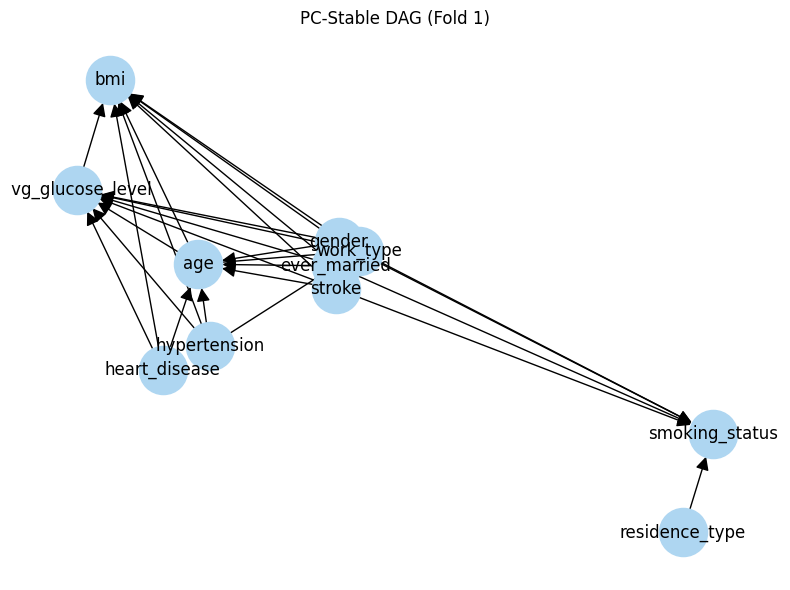

  0%|          | 0/1000000 [00:00<?, ?it/s]

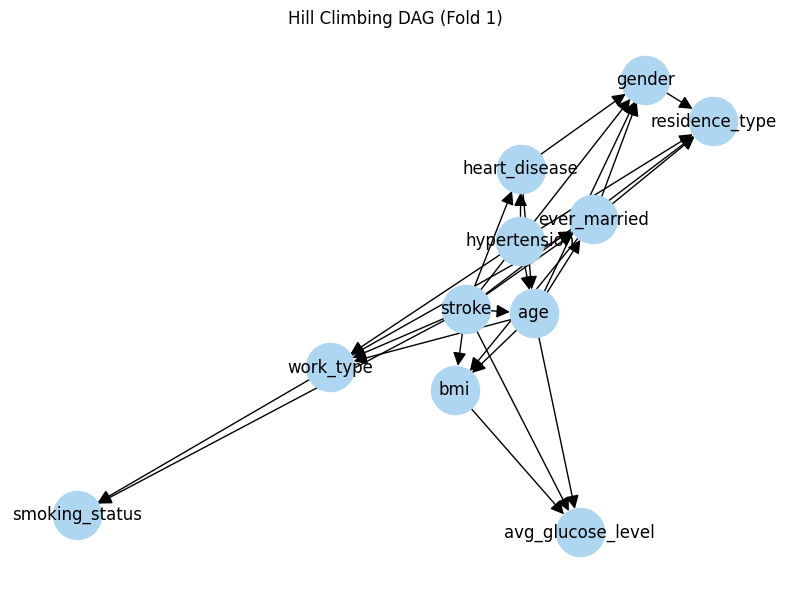

  0%|          | 0/1000000 [00:00<?, ?it/s]

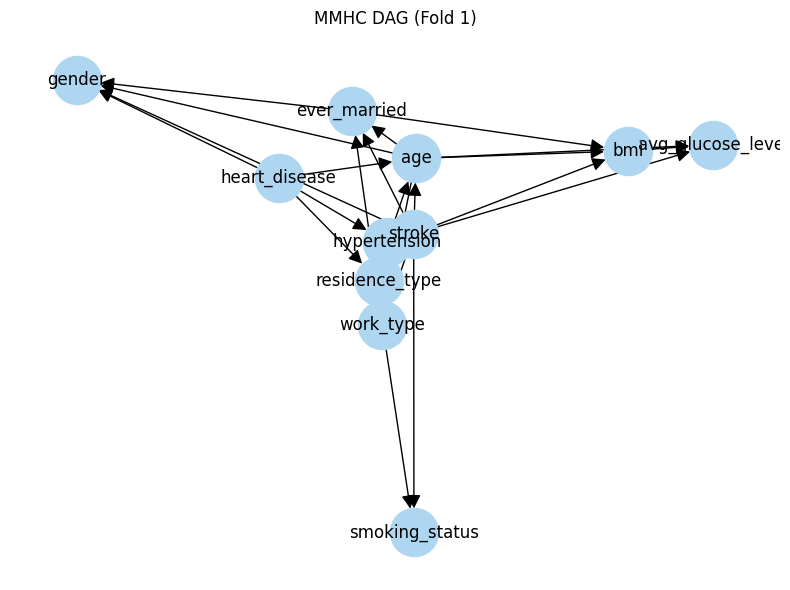

Fold 1 - Markov Blanket of 'stroke':
  PC-Stable:      ['smoking_status', 'gender', 'hypertension', 'heart_disease', 'age', 'work_type', 'ever_married', 'bmi', 'avg_glucose_level', 'residence_type']
  Hill Climbing:  ['gender', 'smoking_status', 'heart_disease', 'hypertension', 'age', 'work_type', 'ever_married', 'bmi', 'avg_glucose_level', 'residence_type']
  MMHC:           ['gender', 'smoking_status', 'hypertension', 'heart_disease', 'age', 'work_type', 'ever_married', 'bmi', 'avg_glucose_level', 'residence_type']


  0%|          | 0/5 [00:00<?, ?it/s]

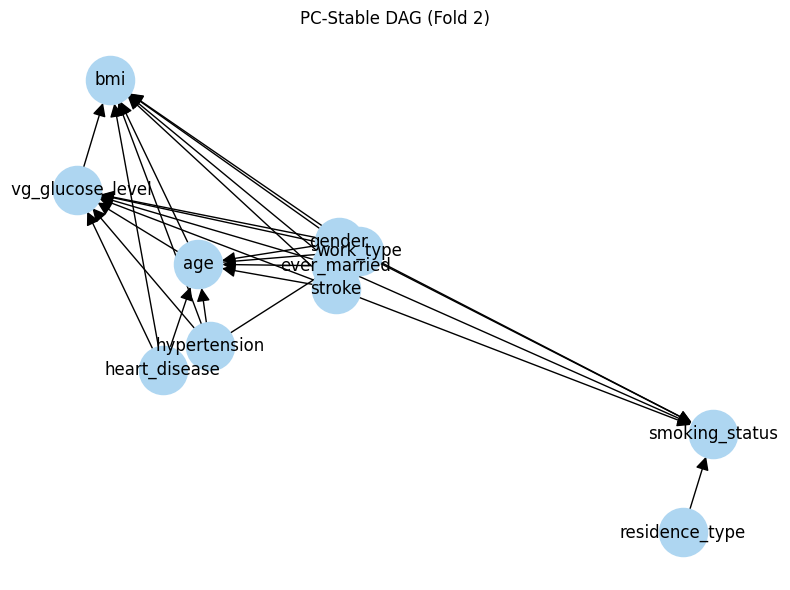

  0%|          | 0/1000000 [00:00<?, ?it/s]

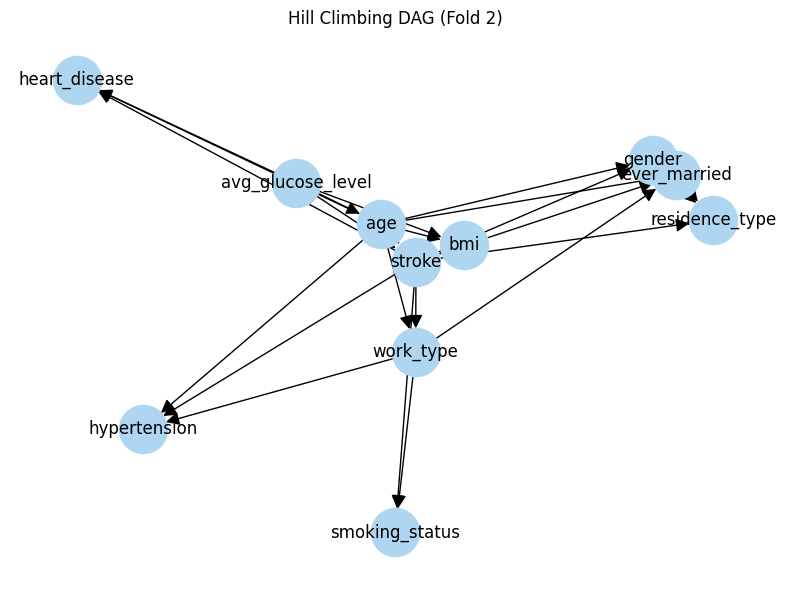

  0%|          | 0/1000000 [00:00<?, ?it/s]

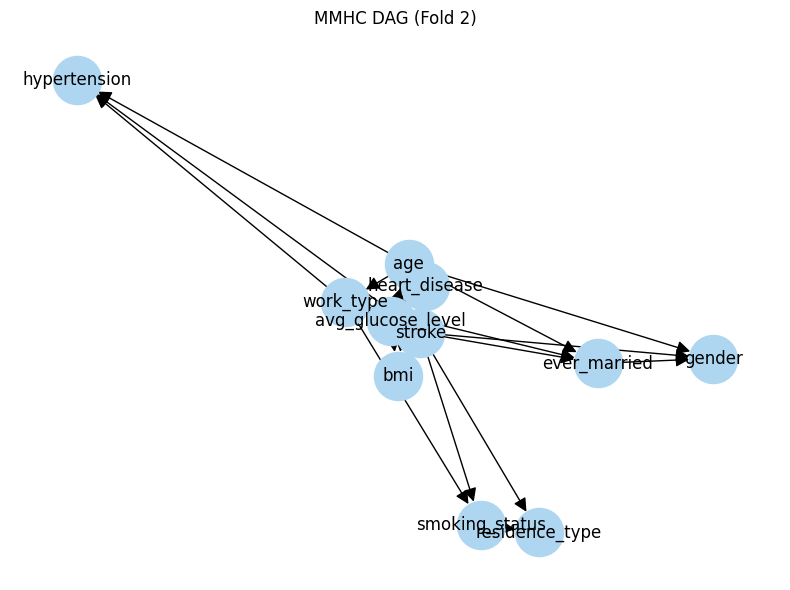

Fold 2 - Markov Blanket of 'stroke':
  PC-Stable:      ['smoking_status', 'gender', 'hypertension', 'heart_disease', 'age', 'work_type', 'ever_married', 'bmi', 'avg_glucose_level', 'residence_type']
  Hill Climbing:  ['smoking_status', 'heart_disease', 'gender', 'hypertension', 'age', 'work_type', 'ever_married', 'bmi', 'avg_glucose_level', 'residence_type']
  MMHC:           ['smoking_status', 'hypertension', 'gender', 'age', 'work_type', 'ever_married', 'bmi', 'avg_glucose_level', 'residence_type']


  0%|          | 0/5 [00:00<?, ?it/s]

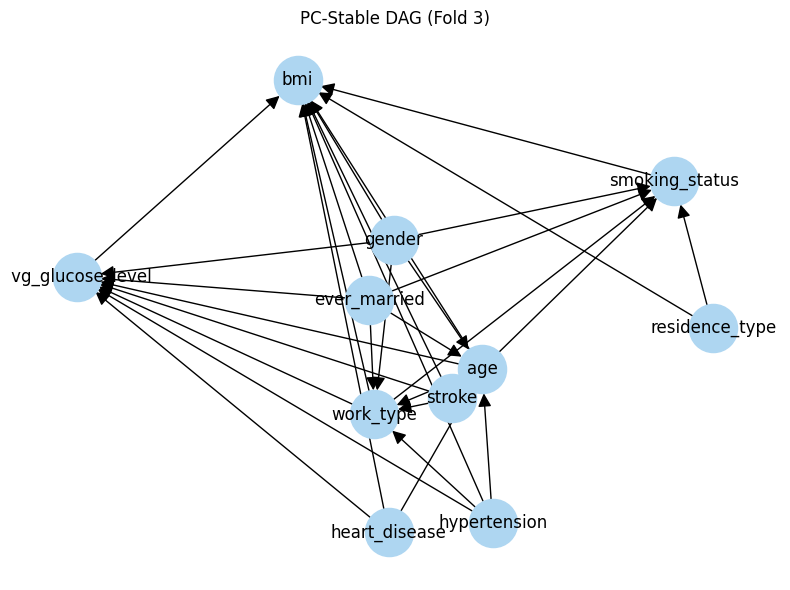

  0%|          | 0/1000000 [00:00<?, ?it/s]

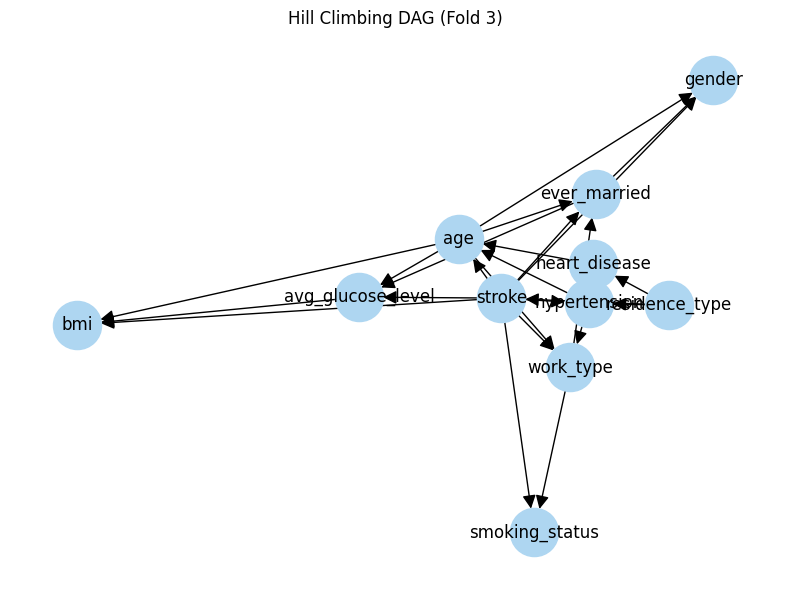

  0%|          | 0/1000000 [00:00<?, ?it/s]

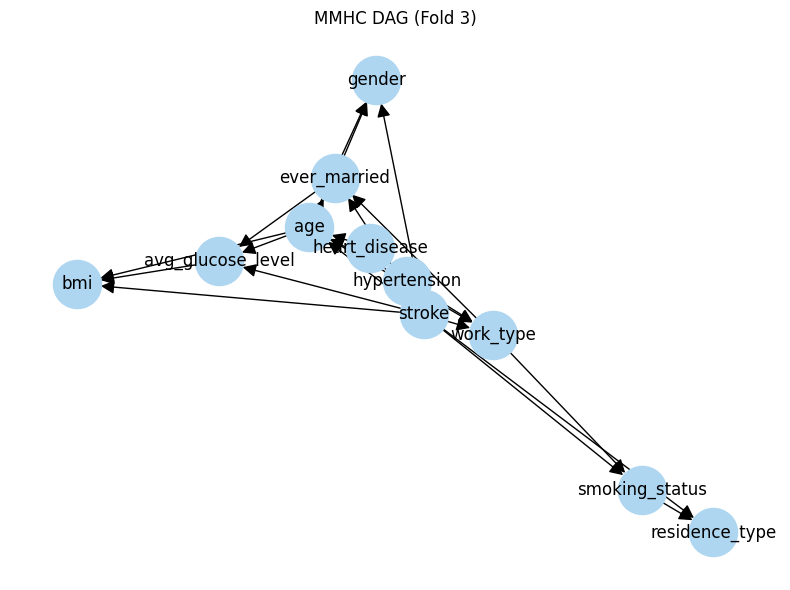

Fold 3 - Markov Blanket of 'stroke':
  PC-Stable:      ['smoking_status', 'gender', 'hypertension', 'heart_disease', 'age', 'work_type', 'ever_married', 'bmi', 'avg_glucose_level', 'residence_type']
  Hill Climbing:  ['gender', 'smoking_status', 'hypertension', 'heart_disease', 'age', 'work_type', 'ever_married', 'bmi', 'avg_glucose_level', 'residence_type']
  MMHC:           ['smoking_status', 'gender', 'hypertension', 'heart_disease', 'age', 'work_type', 'ever_married', 'bmi', 'avg_glucose_level', 'residence_type']


  0%|          | 0/5 [00:00<?, ?it/s]

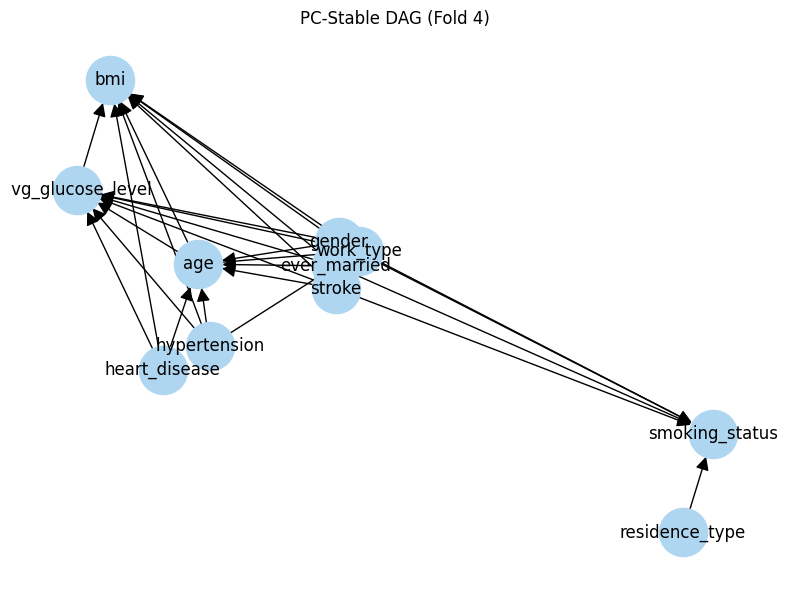

  0%|          | 0/1000000 [00:00<?, ?it/s]

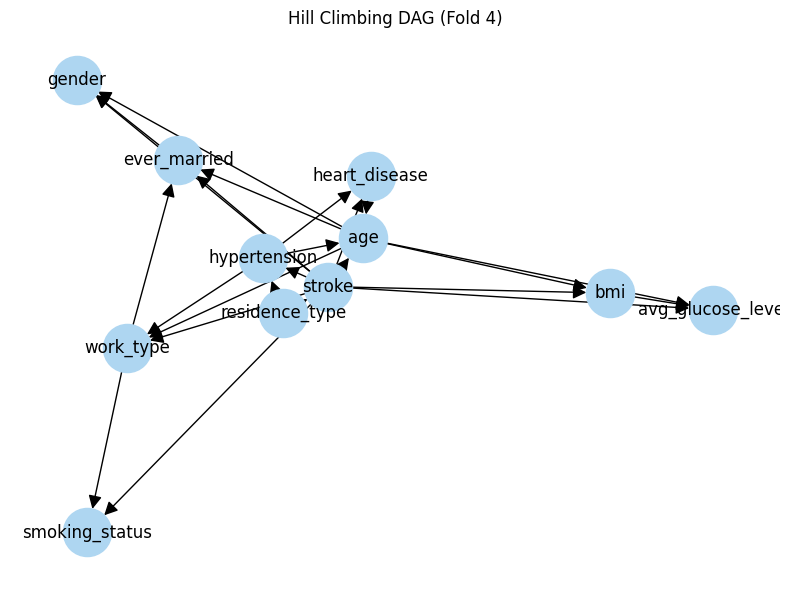

  0%|          | 0/1000000 [00:00<?, ?it/s]

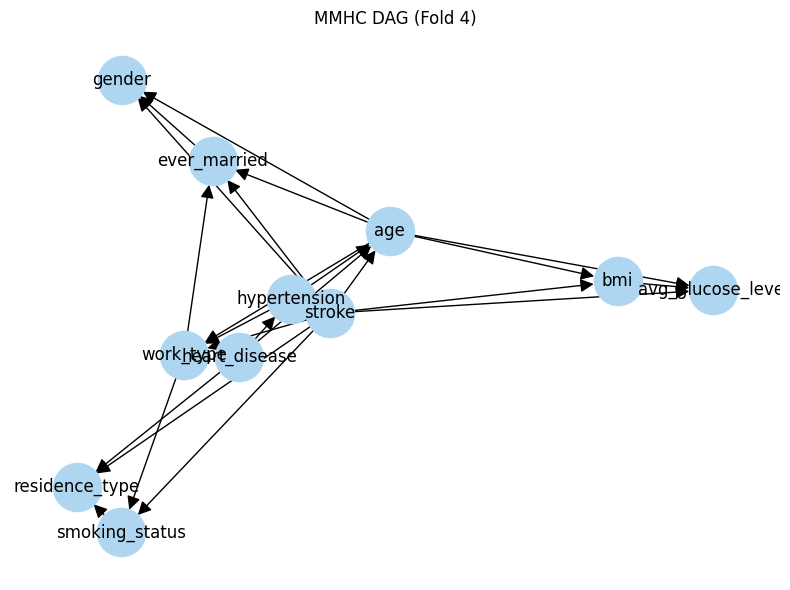

Fold 4 - Markov Blanket of 'stroke':
  PC-Stable:      ['smoking_status', 'gender', 'hypertension', 'heart_disease', 'age', 'work_type', 'ever_married', 'bmi', 'avg_glucose_level', 'residence_type']
  Hill Climbing:  ['gender', 'smoking_status', 'heart_disease', 'hypertension', 'age', 'work_type', 'ever_married', 'bmi', 'avg_glucose_level', 'residence_type']
  MMHC:           ['gender', 'smoking_status', 'hypertension', 'heart_disease', 'age', 'work_type', 'ever_married', 'bmi', 'avg_glucose_level', 'residence_type']


  0%|          | 0/5 [00:00<?, ?it/s]

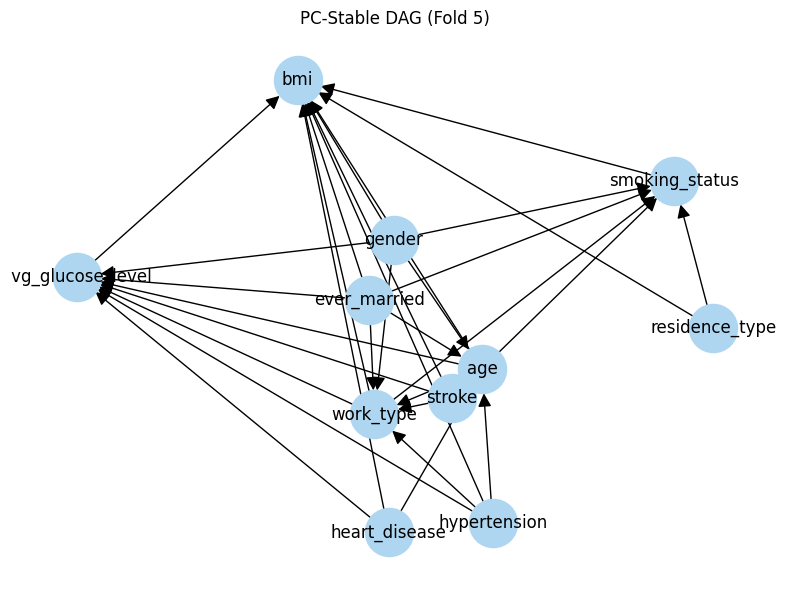

  0%|          | 0/1000000 [00:00<?, ?it/s]

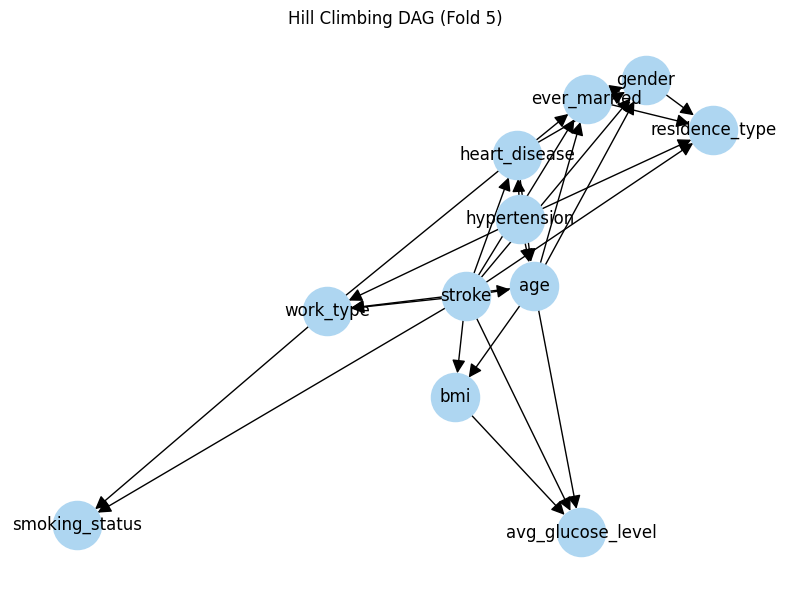

  0%|          | 0/1000000 [00:00<?, ?it/s]

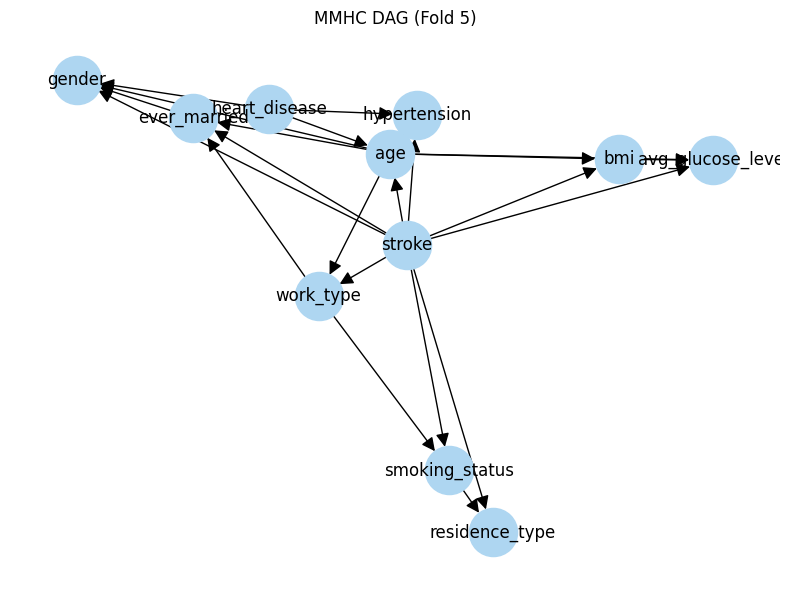

Fold 5 - Markov Blanket of 'stroke':
  PC-Stable:      ['smoking_status', 'gender', 'hypertension', 'heart_disease', 'age', 'work_type', 'ever_married', 'bmi', 'avg_glucose_level', 'residence_type']
  Hill Climbing:  ['gender', 'smoking_status', 'heart_disease', 'hypertension', 'age', 'work_type', 'ever_married', 'bmi', 'avg_glucose_level', 'residence_type']
  MMHC:           ['gender', 'smoking_status', 'hypertension', 'heart_disease', 'age', 'work_type', 'ever_married', 'bmi', 'avg_glucose_level', 'residence_type']


In [73]:
skf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = random_state)

metrics_store = {"pcstable": [], "hillclimbing": [], "mmhc": []}

for fold_idx, (train_idx, test_idx) in enumerate(skf.split(X_disc, y), start = 1):

  test_data_orig = data.iloc[test_idx].reset_index(drop = True)

  # Export test data (original) for this fold
  testdata_path = out_dir / f"testdata_{fold_idx}.csv"
  test_data_orig.to_csv(testdata_path, index = False)

  train_data = data_disc.iloc[train_idx].reset_index(drop = True)
  test_data = data_disc.iloc[test_idx].reset_index(drop = True)

  # Separate features/target for metrics
  y_test = test_data[target].values

  # ------------------
  # Model 1: PC Stable
  # ------------------
  model_pc = learn_pc_stable(train_data, significance_level = significance_level)
  y_pred_pc, y_prob_pc = predict_bn(model_pc, test_data, target)

  # Save results
  res_pc = pd.DataFrame({
      'y_true': y_test,
      'y_pred': y_pred_pc,
      'prob_no_stroke': 1 - y_prob_pc,
      'prob_stroke': y_prob_pc
  })
  res_pc_path = out_dir / f"testresult_pcstable_{fold_idx}.csv"
  res_pc.to_csv(res_pc_path, index = False)

  # Metrics
  metrics_store["pcstable"].append({
      'accuracy': accuracy_score(y_test, y_pred_pc),
      'precision': precision_score(y_test, y_pred_pc, zero_division = 0),
      'recall': recall_score(y_test, y_pred_pc, zero_division = 0),
      'f1': f1_score(y_test, y_pred_pc, zero_division = 0),
      'auc': roc_auc_score(y_test, y_prob_pc) if len(np.unique(y_test)) > 1 else np.nan
  })

  # Plot DAG
  plot_dag(model_pc, f"PC-Stable DAG (Fold {fold_idx})", out_dir / f"dag_pcstable_{fold_idx}.png")

  # Analyze Markov Blanket
  mb_pc = analyze_markov_blanket(model_pc, target)

  # ----------------------
  # Model 2: Hill Climbing
  # ----------------------
  model_hc = learn_hill_climbing(train_data)
  y_pred_hc, y_prob_hc = predict_bn(model_hc, test_data, target)

  # Save results
  res_hc = pd.DataFrame({
      'y_true': y_test,
      'y_pred': y_pred_hc,
      'prob_no_stroke': 1 - y_prob_hc,
      'prob_stroke': y_prob_hc
  })
  res_hc_path = out_dir / f"testresult_hillclimbing_{fold_idx}.csv"
  res_hc.to_csv(res_hc_path, index = False)

  # Metrics
  metrics_store["hillclimbing"].append({
      'accuracy': accuracy_score(y_test, y_pred_hc),
      'precision': precision_score(y_test, y_pred_hc, zero_division = 0),
      'recall': recall_score(y_test, y_pred_hc, zero_division = 0),
      'f1': f1_score(y_test, y_pred_hc, zero_division = 0),
      'auc': roc_auc_score(y_test, y_prob_hc) if len(np.unique(y_test)) > 1 else np.nan
  })

  # Plot DAG
  plot_dag(model_hc, f"Hill Climbing DAG (Fold {fold_idx})", out_dir / f"dag_hillclimbing_{fold_idx}.png")

  # Analyze Markov Blanket
  mb_hc = analyze_markov_blanket(model_hc, target)

  # -----------------
  # Model 3: MMHC
  # -----------------
  model_mmhc = learn_mmhc(train_data, significance_level = significance_level)
  y_pred_mm, y_prob_mm = predict_bn(model_mmhc, test_data, target)

  # Save results
  res_mm = pd.DataFrame({
      'y_true': y_test,
      'y_pred': y_pred_mm,
      'prob_no_stroke': 1 - y_prob_mm,
      'prob_stroke': y_prob_mm
  })
  res_mm_path = out_dir / f"testresult_mmhc_{fold_idx}.csv"
  res_mm.to_csv(res_mm_path, index = False)

  # Metrics
  metrics_store["mmhc"].append({
      'accuracy': accuracy_score(y_test, y_pred_mm),
      'precision': precision_score(y_test, y_pred_mm, zero_division = 0),
      'recall': recall_score(y_test, y_pred_mm, zero_division = 0),
      'f1': f1_score(y_test, y_pred_mm, zero_division = 0),
      'auc': roc_auc_score(y_test, y_prob_mm) if len(np.unique(y_test)) > 1 else np.nan
  })

  # Plot DAG
  plot_dag(model_mmhc, f"MMHC DAG (Fold {fold_idx})", out_dir / f"dag_mmhc_{fold_idx}.png")

  # Analyze Markov Blanket
  mb_mm = analyze_markov_blanket(model_mmhc, target)

  # Print Markov Blanket for interpretability
  print(f"Fold {fold_idx} - Markov Blanket of '{target}':")
  print(f"  PC-Stable:      {mb_pc}")
  print(f"  Hill Climbing:  {mb_hc}")
  print(f"  MMHC:           {mb_mm}")

# 6. COMPARE RESULTS & EVALUATE PERFORMANCE

In [74]:
def calc_sens_spec(y_true, y_pred):      # Calculate the Sensitivity and Specificity scores

   conf_matrix = confusion_matrix(y_true, y_pred)      # Calculate the Confusion Matrix

   TP = conf_matrix[1][1]     # True Positives
   TN = conf_matrix[0][0]     # True Negatives
   FP = conf_matrix[0][1]     # False Positives
   FN = conf_matrix[1][0]     # False Negatives

    # Calculate the Sensitivity score
   sensitivity = TP / (TP + FN)

    # Calculate the Specificity score
   specificity = TN / (TN + FP)

   return sensitivity, specificity

In [75]:
def agg(metrics_list):
  return pd.DataFrame(metrics_list).agg(['mean', 'std'])

perf_pc = agg(metrics_store['pcstable'])
perf_hc = agg(metrics_store['hillclimbing'])
perf_mm = agg(metrics_store['mmhc'])

print("\nAverage performance across 5 folds: ")
print("\nPC-Stable: \n", perf_pc)
print("\nHill Climbing: \n", perf_hc)
print("\nMMHC: \n", perf_mm)


Average performance across 5 folds: 

PC-Stable: 
       accuracy  precision    recall        f1       auc
mean  0.830144   0.797095  0.887037  0.839478  0.904274
std   0.017980   0.025712  0.005009  0.014244  0.023434

Hill Climbing: 
       accuracy  precision    recall        f1       auc
mean  0.850926   0.827983  0.886008  0.855975  0.932196
std   0.002396   0.005880  0.007781  0.002294  0.002834

MMHC: 
       accuracy  precision    recall        f1       auc
mean  0.851543   0.828270  0.887037  0.856603  0.931236
std   0.004695   0.003765  0.012418  0.005415  0.003436


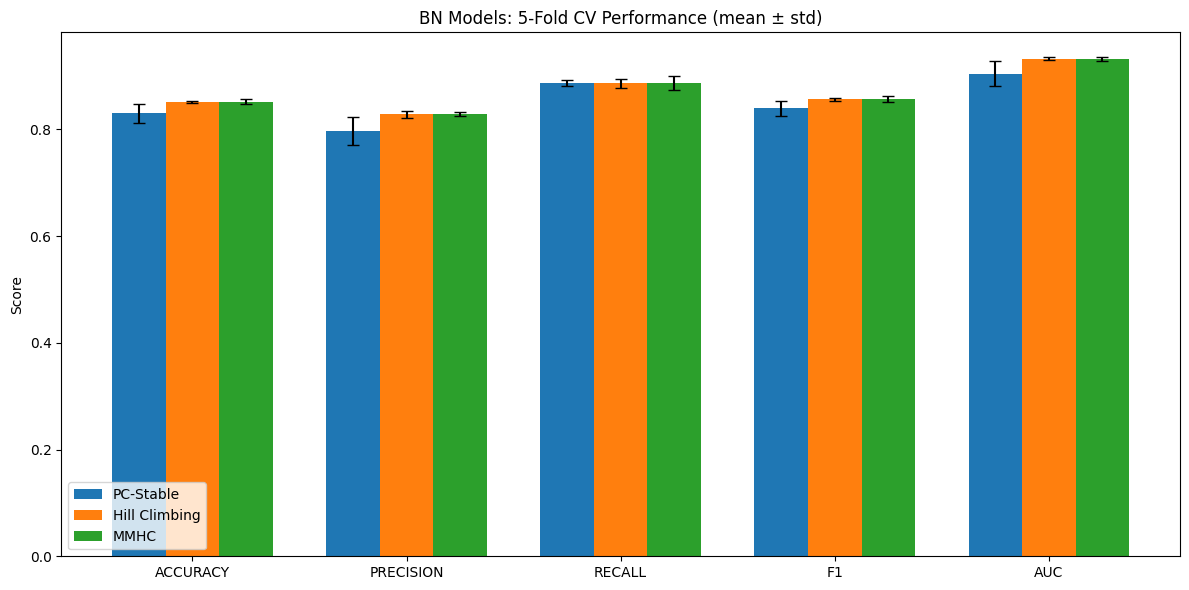

In [76]:
# Plot grouped bars for mean metrics with error bars
metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
means = {
    'PC-Stable': perf_pc.loc['mean', metrics].values,
    'Hill Climbing': perf_hc.loc['mean', metrics].values,
    'MMHC': perf_mm.loc['mean', metrics].values
}
stds = {
    'PC-Stable': perf_pc.loc['std', metrics].values,
    'Hill Climbing': perf_hc.loc['std', metrics].values,
    'MMHC': perf_mm.loc['std', metrics].values
}

x = np.arange(len(metrics))
width = 0.25

plt.figure(figsize = (12, 6))
plt.bar(x - width, means['PC-Stable'], width, yerr = stds['PC-Stable'], label = 'PC-Stable', capsize = 4)
plt.bar(x,         means['Hill Climbing'], width, yerr = stds['Hill Climbing'], label = 'Hill Climbing', capsize = 4)
plt.bar(x + width, means['MMHC'], width, yerr = stds['MMHC'], label = 'MMHC', capsize = 4)
plt.xticks(x, [m.upper() for m in metrics])
plt.ylabel('Score')
plt.title('BN Models: 5-Fold CV Performance (mean ± std)')
plt.legend()
plt.tight_layout()
plt.savefig(out_dir / 'model_performance_summary.png', dpi = 150)
plt.show()